In [424]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.utils import resample
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.model_selection import train_test_split, KFold, cross_val_score, learning_curve
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import warnings
import joblib
warnings.filterwarnings('ignore')

In [425]:
data = pd.read_csv("Medicalpremium.csv")

In [426]:
df = data.copy()

In [427]:
subset_selection_features = ["Age", "AnyTransplants", "AnyChronicDiseases", "HistoryOfCancerInFamily",
                             "NumberOfMajorSurgeries", "BMI"]

In [428]:
def mape(y_true, y_pred):
    mape = mean_absolute_percentage_error(y_true, y_pred)
    print(f"MAPE for data: {mape:.2f}%")

In [429]:
def eval(model, name):
    pred_test = model.predict(X_test)
    pred_train = model.predict(X_train)

    rmse_test = np.sqrt(mean_squared_error(y_test, pred_test))
    rmse_train = np.sqrt(mean_squared_error(y_train, pred_train))

    mape_test = mean_absolute_percentage_error(y_test, pred_test)*100
    mape_train = mean_absolute_percentage_error(y_train, pred_train)*100

    cv = KFold(n_splits=10, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train,
                         scoring="neg_mean_squared_error", cv=cv)
    scores = np.sqrt(-scores)
    cv_mean = np.mean(scores)
    cv_std = np.std(scores)

    row = {'model': name,
           'test_rmse': rmse_test,
           'train_rmse': rmse_train,
           'test_mape': mape_test,
           'train_mape': mape_train,
           'cv_rmse': cv_mean,
           'cv_rmse_std': cv_std}
    return row

In [430]:
summary = pd.DataFrame(columns=['model',
           'test_rmse',
           'train_rmse',
           'test_mape',
           'train_mape',
           'cv_rmse',
           'cv_rmse_std'])

# Custom transformers

In [431]:
class upsample(BaseEstimator, TransformerMixin):
    def __init__(self, category="NumberOfMajorSurgeries", cls=3, nSamples=100):
        self.category = category
        self.nSamples = nSamples
        self.cls = cls

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        sample = resample(X[X[self.category] == self.cls], n_samples=self.nSamples, replace=True)
        X = pd.concat([X[X[self.category] != self.cls], sample])
        X.reset_index(drop=True, inplace=True)
        return X

In [432]:
class BMI(BaseEstimator, TransformerMixin):
    def __init__(self, bmi=True, bmiCat=True, dropbmi=False):
        self.bmi = bmi
        self.bmiCat = bmiCat
        self.dropbmi = dropbmi

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        if self.bmi:
            X["BMI"] = X["Weight"]/(X["Height"]/100)**2
            X = X.drop(["Weight", "Height"], axis=1)
            
            if self.bmiCat:
                bins = [0, 18.5, 24.9, 29.9, 34.9, 100]
                labels = ['Underweight', 'Normal', 'Overweight', 'Obese', 'Extreme']
                X["BMI_cat"] = pd.cut(X["BMI"], bins=bins, labels=labels, right=False)
                if self.dropbmi:
                    X = X.drop("BMI", axis=1)
                    return X
                else:
                    #X = X.drop(["Weight", "Height"], axis=1)
                    return X
            else:
                #X = X.drop(["Weight", "Height"], axis=1)
                return X
        else:
            return X

In [433]:
class oneHot(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
        self.encoder = OneHotEncoder(sparse=False, drop='first')

    def fit(self, X, y=None):
        self.encoder.fit(X[self.columns])
        return self

    def transform(self, X, y=None):
        onehot_encoded = self.encoder.transform(X[self.columns])
        feature_names = self.encoder.get_feature_names_out()
        result_df = pd.DataFrame(onehot_encoded, columns=feature_names, index=X.index)
        return pd.concat([X.drop(columns=self.columns), result_df], axis=1)

In [434]:
class StdScaler(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
        self.scaler = StandardScaler()

    def fit(self, X, y=None):
        if (self.columns is None):
            num_cols = [i for i in X.columns if len(np.unique(X[i])) > 5]
            self.columns = num_cols
        self.scaler.fit(X[self.columns])
        return self

    def transform(self, X, y=None):
        scaled_data = self.scaler.transform(X[self.columns])
        result_df = pd.DataFrame(scaled_data, columns=self.columns, index=X.index)
        return pd.concat([X.drop(columns=self.columns), result_df], axis=1)

In [435]:
class featureSelection(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        if (self.columns is None):
            self.columns = X.columns
        return X[self.columns]

# preprocessing

In [436]:
#dt = upsample(category= "NumberOfMajorSurgeries", cls=3, nSamples=100).transform(df.copy())
dt = df.copy()

In [437]:
df

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,PremiumPrice
0,45,0,0,0,0,155,57,0,0,0,25000
1,60,1,0,0,0,180,73,0,0,0,29000
2,36,1,1,0,0,158,59,0,0,1,23000
3,52,1,1,0,1,183,93,0,0,2,28000
4,38,0,0,0,1,166,88,0,0,1,23000
...,...,...,...,...,...,...,...,...,...,...,...
981,18,0,0,0,0,169,67,0,0,0,15000
982,64,1,1,0,0,153,70,0,0,3,28000
983,56,0,1,0,0,155,71,0,0,1,29000
984,47,1,1,0,0,158,73,1,0,1,39000


In [438]:
X = dt.drop("PremiumPrice", axis=1)
y = dt.PremiumPrice.copy()

In [439]:
X.shape

(986, 10)

In [440]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [441]:
pipe1 = Pipeline([
    ('bmi', BMI(bmiCat=False)),
    #('oneHot', oneHot(columns=["BMI_cat"])),
    ('scaler', StdScaler()),
    ('feature_selction', featureSelection())
])

In [442]:
pipe2 = Pipeline([
    ('bmi', BMI(bmiCat=False)),
    #('oneHot', oneHot(columns=["BMI_cat"])),
    ('scaler', StdScaler()),
    ('feature_selction', featureSelection(subset_selection_features))
])

# Random Forest

In [443]:
from sklearn.ensemble import RandomForestRegressor

In [444]:
X_train = pipe1.fit_transform(x_train.copy())
X_test = pipe1.fit_transform(x_test.copy())

In [445]:
forest_reg = RandomForestRegressor(random_state=42, max_depth=6, n_estimators=300, n_jobs=-1, min_samples_leaf=2)

In [446]:
forest_reg.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 6,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [447]:
forest_reg.fit(X_train, y_train)

RandomForestRegressor(max_depth=6, min_samples_leaf=2, n_estimators=300,
                      n_jobs=-1, random_state=42)

In [448]:
pred = forest_reg.predict(X_test)

In [449]:
np.sqrt(mean_squared_error(y_test, pred))

2759.181477662578

In [450]:
#train rmse
np.sqrt(mean_squared_error(y_train, forest_reg.predict(X_train)))

2412.6587065737417

In [451]:
mape(y_test, pred)

MAPE for data: 0.06%


In [452]:
forest_test_r2=r2_score(y_test,pred)
forest_test_r2

0.8263584593104386

In [453]:
forest_train_r2=r2_score(y_train,forest_reg.predict(X_train))
forest_train_r2

0.8419626642910911

[0.00461834 0.0059492  0.09963962 0.04751109 0.00286797 0.02064453
 0.0226604  0.70762174 0.0884871 ]


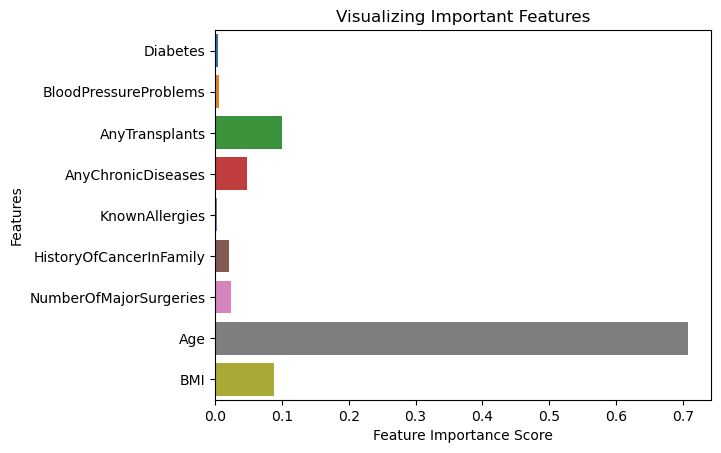

In [396]:
feature_imp1 = forest_reg.feature_importances_
print(feature_imp1)

sns.barplot(x=feature_imp1, y=X_train.columns)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

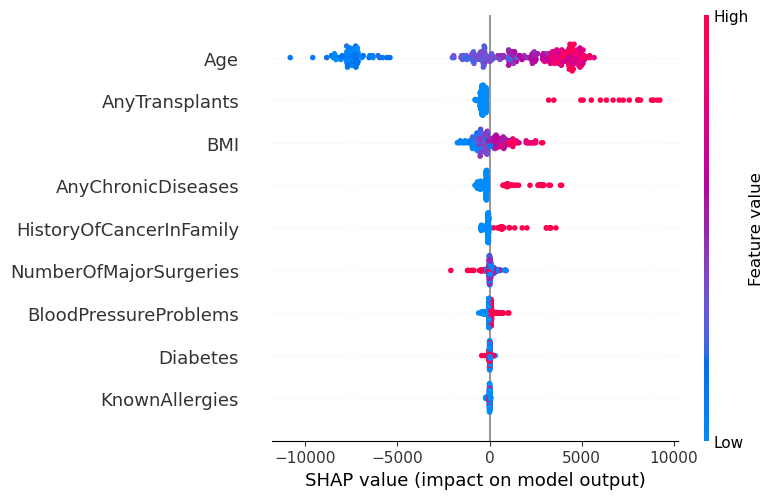

In [397]:
import shap
explainer1 = shap.TreeExplainer(forest_reg)
RF_shap_values = explainer1.shap_values(X_test)
shap.summary_plot(RF_shap_values, X_test)

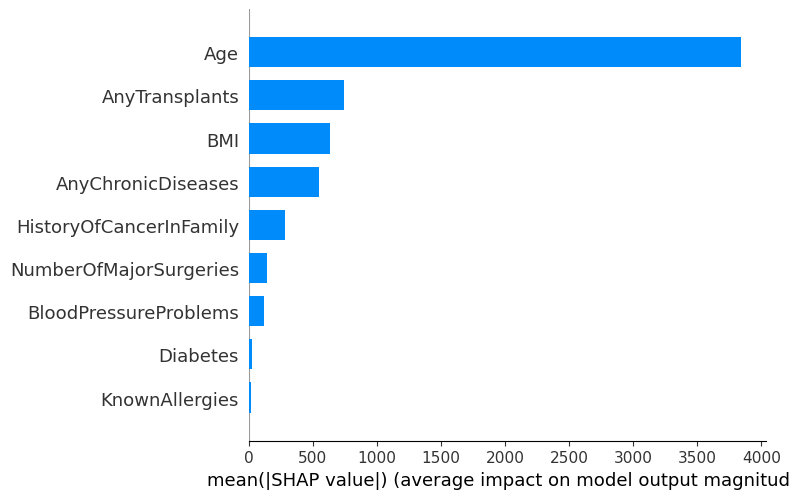

In [398]:
shap.summary_plot(RF_shap_values, X_test, plot_type="bar")

In [209]:
# from sklearn.inspection import partial_dependence
# import matplotlib.pyplot as plt

# features = [0]  # List of features you want to analyze, e.g., [0] for the first feature
# pdp, axes = partial_dependence(forest_reg, X_test, features=features, grid_resolution=100)
# plt.figure()
# plt.plot(axes[0][0], pdp[0], '-')
# plt.ylabel('Partial Dependence')
# plt.xlabel('Feature Values')
# plt.title('Partial Dependence Plot')
# plt.grid()
# plt.show()

In [ ]:
# from pdpbox import pdp
# pdp_A = pdp.pdp_isolate(model=forest_reg,                  
#                           dataset=X_test,                              
#                           model_features=['A','B','C','D'] 
#                           feature='A')

In [210]:
X_test

,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,Age,BMI
613,0,0,0,0,1,1,1,0.574332,0.579845
451,0,0,0,1,1,1,1,-0.216042,-1.036740
731,1,1,0,0,0,0,0,1.652114,0.766873
436,0,0,0,0,0,1,1,-0.934563,-0.948894
275,1,1,0,0,1,0,0,0.430627,0.218798
...,...,...,...,...,...,...,...,...,...
767,0,1,0,0,0,0,2,1.221001,-0.776559
559,0,1,0,0,0,0,0,-1.437529,0.271405
319,1,1,0,0,0,0,1,-0.000485,-1.428812
591,0,1,0,0,0,0,0,-0.790859,0.455164


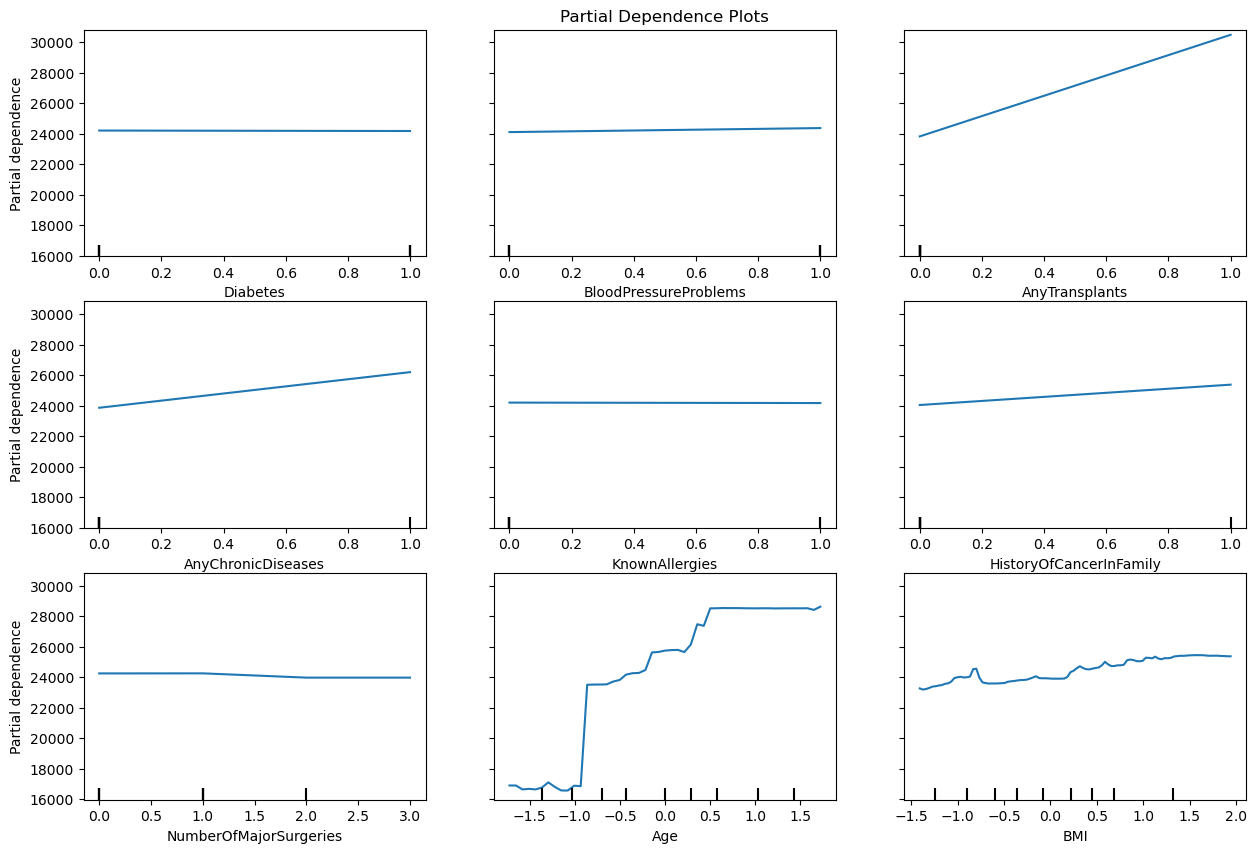

In [399]:
from sklearn.inspection import PartialDependenceDisplay
fig, ax = plt.subplots(figsize=(15, 10))
ax.set_title("Partial Dependence Plots")
PartialDependenceDisplay.from_estimator(
    estimator=forest_reg,
    X=X_test,
    features=(0, 1, 2, 3,4,5,6,7,8), # the features to plot
    #categorical_features = (0, 1, 2, 3,4,5,6), # categorical features
    random_state=5,
    ax=ax,
)
plt.show()

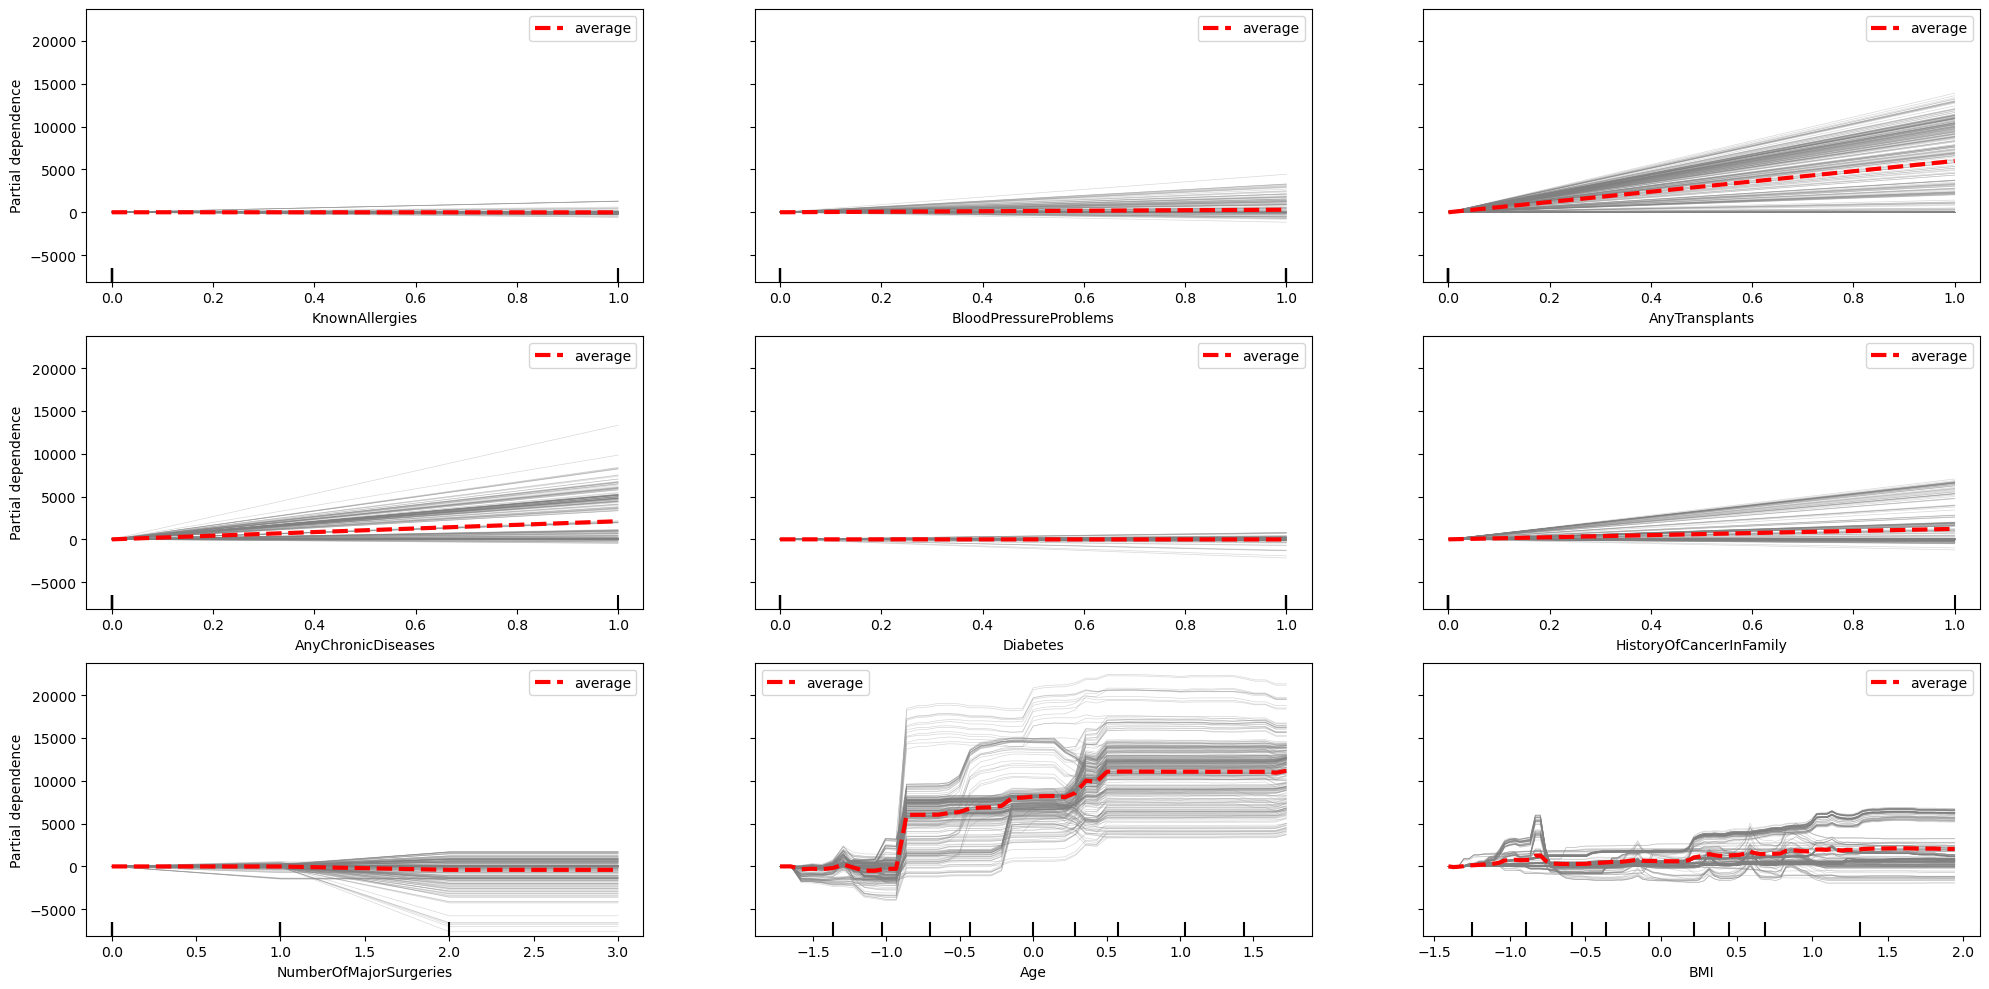

In [400]:
cols = X_test.columns
# Determine the 9 features with highest value for "feature importance" to draw the ICE plots.
included_features_indices = np.argpartition(forest_reg.feature_importances_, -9)[-9:]

# Plot the ICE plots.
fig, ax = plt.subplots(figsize=(20, 10))
fig.set_tight_layout(True)  # Make sure labels of axes don't overlap in the final figure.
_ = PartialDependenceDisplay.from_estimator(estimator=forest_reg,
                                            ax=ax,
                                            X=X_test,
                                            features=[i for i in included_features_indices],
                                            feature_names=cols,
                                            n_cols=3,
                                            centered= True,
                                            kind='both',
                                            ice_lines_kw={'color': 'gray'},
                                            pd_line_kw={'color': 'red', 'linewidth': 3, 'linestyle': 'dashed'})

In [223]:
# from pdpbox import pdp
# pdp_age = pdp.PDPIsolate(
#     model=forest_reg,
#     df=pd.concat([X_test, y_test], axis=1),
#     model_features=X_test.columns, 
#     feature="Age",
#     #feature_name="Age",
# )
# fig, axes = pdp_transplants.plot(
#     center=False,
#     plot_lines=False,
#     plot_pts_dist=False,
#     to_bins=False,
#     engine='matplotlib',
# )
# fig.set_figheight(5)

# fig, axes = pdp_age.plot(
#     center=True,
#     plot_lines=False, 
#     show_percentile=True,
#     plot_pts_dist=True,
#     to_bins=True, 
#     engine='matplotlib', 
# )
# fig.set_figheight(6)

In [224]:
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence

ImportError: cannot import name 'plot_partial_dependence' from 'sklearn.inspection' (C:\Users\CC\anaconda3\Lib\site-packages\sklearn\inspection\__init__.py)

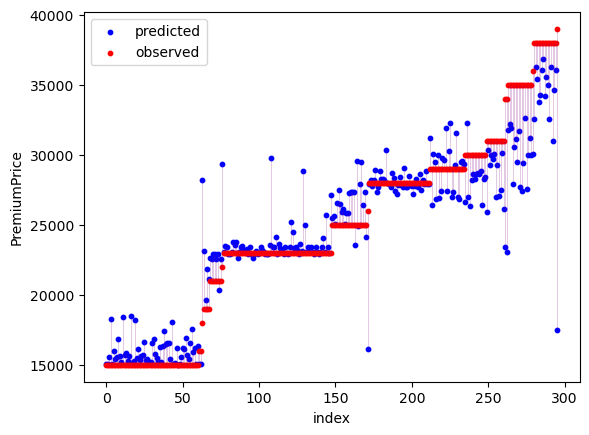

In [37]:
temp = pd.DataFrame({'Observed':y_test, 'predicted':pred})
temp.sort_values('Observed', inplace=True)
temp.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots()

ax.vlines(temp.index, temp.Observed, temp.Observed - (temp.Observed - temp.predicted), color='purple', linestyle='-', linewidth=0.5, alpha=0.3)

ax.scatter(temp.index, temp.predicted, color='blue', marker='o', label='predicted', s=10)
ax.scatter(temp.index, temp.Observed, color='red', marker='o', label='observed', s=10)

ax.set_xlabel('index')
ax.set_ylabel("PremiumPrice")
ax.legend()

plt.show()

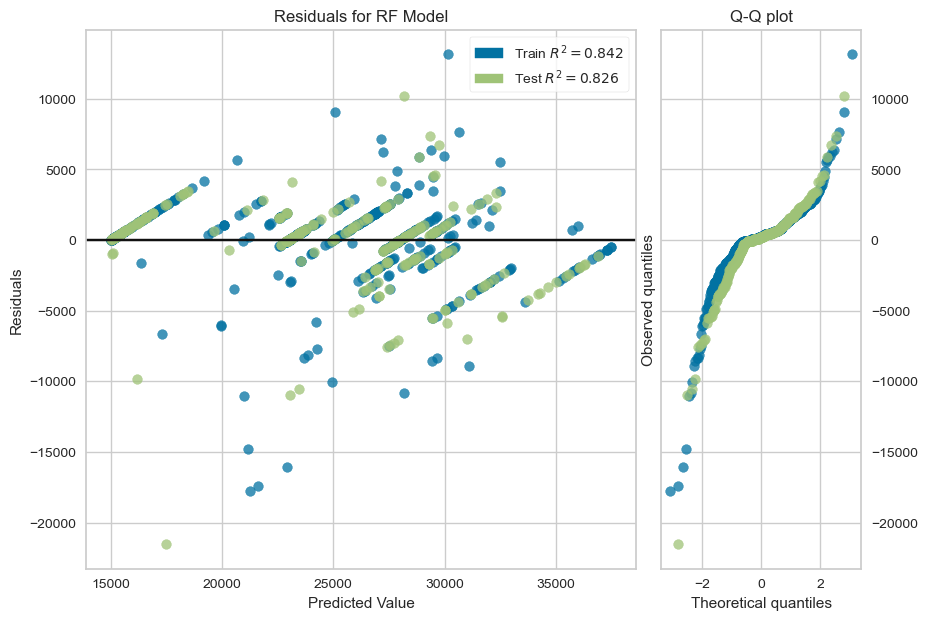

In [404]:
from yellowbrick.regressor import residuals_plot
fig, ax = plt.subplots(figsize=(10, 7))
_ = residuals_plot(estimator=forest_reg,
                   is_fitted=True,
                   ax=ax,
                   X_train=X_train,
                   y_train=y_train,
                   X_test=X_test,
                   y_test=y_test,
                   hist=False,
                   qqplot=True,
                  title="Residuals for RF Model"
                  )


In [403]:
pip install yellowbrick 

  Obtaining dependency information for yellowbrick from https://files.pythonhosted.org/packages/06/35/c7d44bb541c06bc41b3239b27af79ea0ecc7dbb156ee1335576f99c58b91/yellowbrick-1.5-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/282.6 kB ? eta -:--:--
   - -------------------------------------- 10.2/282.6 kB ? eta -:--:--
   ---- ---------------------------------- 30.7/282.6 kB 435.7 kB/s eta 0:00:01
   -------- ------------------------------ 61.4/282.6 kB 656.4 kB/s eta 0:00:01
   --------------------------- ------------ 194.6/282.6 kB 1.3 MB/s eta 0:00:01
   ---------------------------------------- 282.6/282.6 kB 1.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


## cross validation forest

In [38]:
cv = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(forest_reg, X_train, y_train,
                         scoring="neg_mean_squared_error", cv=cv)

In [39]:
forest_rmse_scores = np.sqrt(-scores)

In [40]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [41]:
display_scores(forest_rmse_scores)

Scores: [3656.7888214  3467.58530969 4257.99823853 2422.6002467  3343.44925268
 3453.82458658 2439.53952098 2745.44801277 2546.291024   3786.3070252 ]
Mean: 3211.9832038527284
Standard deviation: 603.6179432340606


## learning curve

In [42]:
train_sizes, train_scores, validation_scores = learning_curve(
estimator = forest_reg,
X = X_train,
y = y_train,
    cv = 5,
scoring = 'neg_mean_squared_error')

In [43]:
train_scores = np.sqrt(-train_scores)
validation_scores = np.sqrt(-validation_scores)

In [44]:
train_scores_mean = np.mean(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)

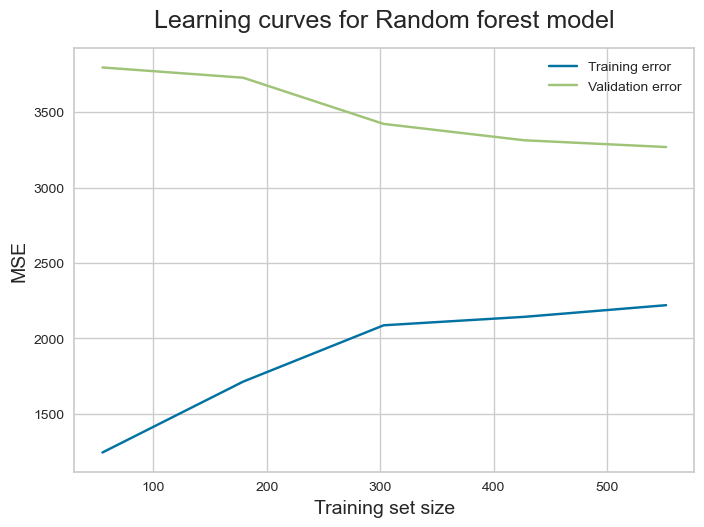

In [405]:
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for Random forest model', fontsize = 18, y = 1.03)
plt.legend()

In [46]:
summary.loc[len(summary.index)] =eval(forest_reg, "random forset")

In [47]:
summary

,model,test_rmse,train_rmse,test_mape,train_mape,cv_rmse,cv_rmse_std
0,random forset,2759.181478,2412.658707,6.283566,5.334523,3211.983204,603.617943


## feature selected

In [454]:
X_train = pipe2.fit_transform(x_train.copy())
X_test = pipe2.fit_transform(x_test.copy())

In [455]:
forest_reg.fit(X_train, y_train)

RandomForestRegressor(max_depth=6, min_samples_leaf=2, n_estimators=300,
                      n_jobs=-1, random_state=42)

In [456]:
pred = forest_reg.predict(X_test)
np.sqrt(mean_squared_error(y_test, pred))

2775.7037458459404

In [457]:
#train rmse
np.sqrt(mean_squared_error(y_train, forest_reg.predict(X_train)))

2469.558348912413

In [458]:
mape(y_test,pred)

MAPE for data: 0.06%


In [459]:
mape(y_train,forest_reg.predict(X_train))

MAPE for data: 0.05%


In [460]:
forest_testf_r2=r2_score(y_test,pred)
forest_testf_r2

0.8242726654476982

In [462]:
forest_trainf_r2=r2_score(y_train,forest_reg.predict(X_train))
forest_trainf_r2

0.8344205252035128

In [44]:
#cross validation
scores = cross_val_score(forest_reg, X_train, y_train, scoring='neg_mean_squared_error', cv=10)

display_scores(np.sqrt(-scores))

Scores: [3392.4170916  3633.77495129 3303.62101521 3752.85716772 4129.64468346
 3723.18035741 2011.61461671 2271.70109318 2169.08386523 3661.87348699]
Mean: 3204.9768328786013
Standard deviation: 723.1456642984705


## hyperparameter forest

### RandomizedGridSearch

In [45]:
forest_reg.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 6,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [46]:
from sklearn.model_selection import RandomizedSearchCV

In [47]:
n_estimators = [int(i) for i in np.linspace(200, 2000, 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(i) for i in np.linspace(10, 110, 11)]
max_depth.append(None)
min_sample_split = [2, 5, 10]
min_sample_leaf = [1, 2, 4]
bootstrap = [True, False]

In [48]:
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_sample_split,
               'min_samples_leaf': min_sample_leaf,
               'bootstrap': bootstrap}
random_grid

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
 'max_features': ['log2', 'sqrt'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

In [49]:
X_train = pipe1.fit_transform(x_train.copy())
X_test = pipe1.fit_transform(x_test.copy())

In [50]:
forest_reg = RandomForestRegressor(random_state=42)

In [51]:
forest_rgrid = RandomizedSearchCV(estimator=forest_reg,
                                  param_distributions=random_grid,
                                  cv=3,
                                  verbose=2,
                                  random_state=42,
                                  n_jobs=-1,
                                  scoring='neg_mean_squared_error',
                                  return_train_score=True,
                                  n_iter=100)

In [52]:
score = forest_rgrid.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


#### saving

In [53]:
#joblib.dump(score, "forest1.pkl")
#score = joblib.load("forest1.pkl")

In [54]:
score.best_params_

{'n_estimators': 2000,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': False}

In [55]:
cvres = score.cv_results_

temp = pd.DataFrame(cvres['params'])
temp["rmse"] = np.sqrt(-cvres["mean_test_score"])
temp.sort_values("rmse").head(20)

,n_estimators,min_samples_split,min_samples_leaf,max_features,max_depth,bootstrap,rmse
12,2000,10,1,sqrt,10.0,False,3376.308933
20,1800,10,1,sqrt,30.0,False,3378.326148
68,1000,10,1,sqrt,80.0,False,3383.422208
85,600,10,1,sqrt,40.0,False,3386.863387
56,1600,5,1,log2,10.0,True,3388.569622
18,1800,10,2,log2,110.0,False,3388.992285
2,1200,5,2,sqrt,10.0,False,3389.068716
1,2000,5,1,sqrt,10.0,True,3389.248598
74,1600,5,1,log2,90.0,True,3389.507234
77,2000,5,1,sqrt,100.0,True,3391.297034


In [56]:
best_forest_rgrid = score.best_estimator_

In [57]:
pred = best_forest_rgrid.predict(X_test)

In [58]:
np.sqrt(mean_squared_error(y_test, pred))

2984.7908379294563

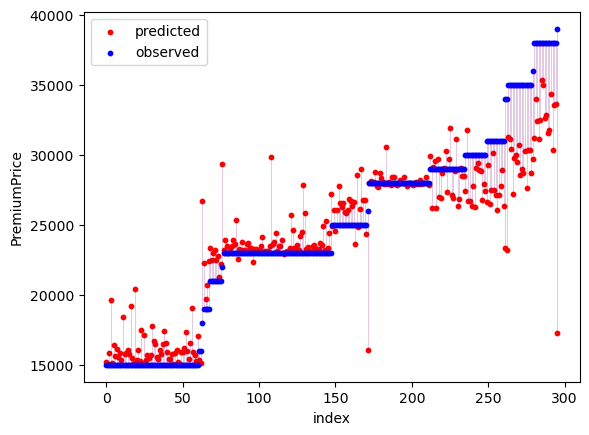

In [59]:
temp = pd.DataFrame({'Observed':y_test, 'predicted':pred})
temp.sort_values('Observed', inplace=True)
temp.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots()

ax.vlines(temp.index, temp.Observed, temp.Observed - (temp.Observed - temp.predicted), color='purple', linestyle='-', linewidth=0.5, alpha=0.3)

ax.scatter(temp.index, temp.predicted, color='red', marker='o', label='predicted', s=10)
ax.scatter(temp.index, temp.Observed, color='blue', marker='o', label='observed', s=10)

ax.set_xlabel('index')
ax.set_ylabel("PremiumPrice")
ax.legend()

plt.show()

In [60]:
pred = best_forest_rgrid.predict(X_train)
np.sqrt(mean_squared_error(y_train, pred))

2133.3620438196363

### GridSearch

In [253]:
from sklearn.model_selection import GridSearchCV

In [62]:
X_train = pipe1.fit_transform(x_train.copy())
X_test = pipe1.fit_transform(x_test.copy())

In [63]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [4, 5, 6],
    'max_features': ['sqrt', 'log2', None],
    'min_samples_leaf': [1, 2, 3],
    'n_estimators': [100, 300, 500]
}

In [64]:
forest_reg2 = RandomForestRegressor(random_state=42)

In [65]:
forest_grid = GridSearchCV(estimator = forest_reg2, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [66]:
score = forest_grid.fit(X_train, y_train)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


#### saving

In [67]:
#joblib.dump(score, "forest2.pkl")
#score = joblib.load("forest2.pkl")

In [68]:
best_forest_grid = score.best_estimator_

In [69]:
score.best_params_

{'bootstrap': True,
 'max_depth': 6,
 'max_features': None,
 'min_samples_leaf': 2,
 'n_estimators': 300}

In [70]:
best_forest_grid

RandomForestRegressor(max_depth=6, max_features=None, min_samples_leaf=2,
                      n_estimators=300, random_state=42)

In [71]:
pred = best_forest_grid.predict(X_test)

In [72]:
np.sqrt(mean_squared_error(y_test, pred))

2759.181477662577

In [73]:
# train rmse
np.sqrt(mean_squared_error(y_train, best_forest_grid.predict(X_train)))

2412.6587065737413

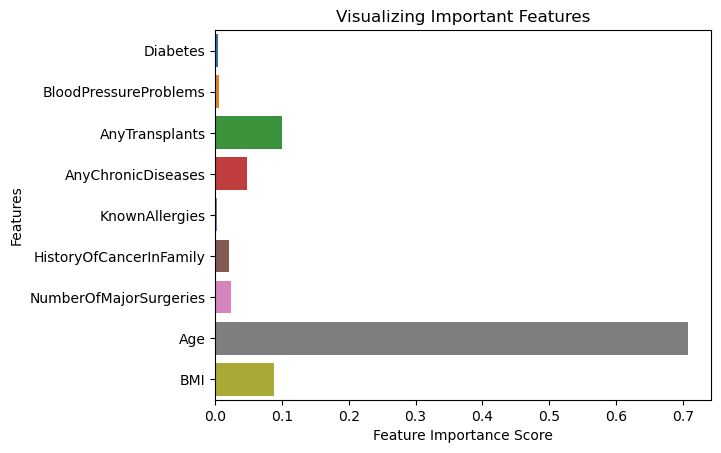

In [74]:
feature_imp1 = best_forest_grid.feature_importances_


sns.barplot(x=feature_imp1, y=X_test.columns)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

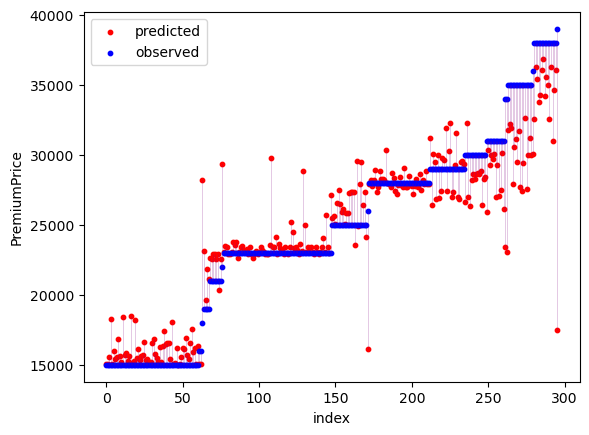

In [75]:
temp = pd.DataFrame({'Observed':y_test, 'predicted':pred})
temp.sort_values('Observed', inplace=True)
temp.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots()

ax.vlines(temp.index, temp.Observed, temp.Observed - (temp.Observed - temp.predicted), color='purple', linestyle='-', linewidth=0.5, alpha=0.3)

ax.scatter(temp.index, temp.predicted, color='red', marker='o', label='predicted', s=10)
ax.scatter(temp.index, temp.Observed, color='blue', marker='o', label='observed', s=10)

ax.set_xlabel('index')
ax.set_ylabel("PremiumPrice")
ax.legend()

plt.show()

### cv

In [76]:
forest_cv = cross_val_score(score.best_estimator_, X_train, y_train, cv=10, scoring='neg_mean_squared_error')

In [77]:
forest_rmse = np.sqrt(-forest_cv)
display_scores(forest_rmse)

Scores: [3443.98969946 3596.59581388 3399.48993602 3615.6123242  4133.26209702
 3798.45045256 1956.56458302 2200.89268574 2265.9477664  3623.09767881]
Mean: 3203.390303711799
Standard deviation: 724.8563635965833


# Decision tree

In [486]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

In [487]:
tree_reg = DecisionTreeRegressor(max_depth=6, random_state=42, min_samples_leaf=2)

In [488]:
tree_reg.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 6,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

In [489]:
X_train = pipe1.fit_transform(x_train.copy())
X_test = pipe1.fit_transform(x_test.copy())

In [490]:
tree_reg.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=6, min_samples_leaf=2, random_state=42)

In [491]:
pred = tree_reg.predict(X_test)
np.sqrt(mean_squared_error(y_test, pred))

3663.19724099846

In [492]:
## train rmse
np.sqrt(mean_squared_error(y_train, tree_reg.predict(X_train)))

2498.9127020776523

In [493]:
descT_train_r2=r2_score(y_train,tree_reg.predict(X_train))
descT_train_r2

0.8304608168863896

In [494]:
descT_test_r2=r2_score(y_test,pred)
descT_test_r2

0.6939349741013623

### cv

In [55]:
cv = KFold(n_splits=10,shuffle=True,random_state=42)
scores = cross_val_score(tree_reg, X_train, y_train, scoring='neg_mean_squared_error', cv=cv)
display_scores(np.sqrt(-scores))

Scores: [3749.25397352 3801.07851905 4417.91642167 2275.54306928 3543.84412997
 4008.52255936 2777.52601341 2774.2959562  3434.23454581 3986.42893795]
Mean: 3476.8644126229765
Standard deviation: 635.5595428046367


In [56]:
crossvalidation=KFold(n_splits=10,shuffle=True,random_state=42)
for depth in range (1,10):
     tree_regressor=DecisionTreeRegressor(max_depth=depth,random_state=42, min_samples_leaf=2)
     if tree_regressor.fit(X_train,y_train).tree_.max_depth<depth:
         break
     score=np.mean(cross_val_score(tree_regressor,X_train,y_train,scoring='neg_mean_squared_error', cv=crossvalidation,n_jobs=1))
     print(depth, np.sqrt(-score))

1 4335.112021947933
2 4107.961626941019
3 3683.6339078824853
4 3601.2710609094875
5 3674.3213931460223
6 3534.4762095979872
7 3659.532331437254
8 3779.71190876779
9 3835.717644801662


In [57]:
summary.loc[len(summary.index)] = eval(tree_reg, "Decision tree")

In [58]:
summary

,model,test_rmse,train_rmse,test_mape,train_mape,cv_rmse,cv_rmse_std
0,random forset,2759.181478,2412.658707,6.283566,5.334523,3211.983204,603.617943
1,Decision tree,3663.197241,2498.912702,6.611471,4.647622,3476.864413,635.559543


In [63]:
df

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,PremiumPrice
0,45,0,0,0,0,155,57,0,0,0,25000
1,60,1,0,0,0,180,73,0,0,0,29000
2,36,1,1,0,0,158,59,0,0,1,23000
3,52,1,1,0,1,183,93,0,0,2,28000
4,38,0,0,0,1,166,88,0,0,1,23000
...,...,...,...,...,...,...,...,...,...,...,...
981,18,0,0,0,0,169,67,0,0,0,15000
982,64,1,1,0,0,153,70,0,0,3,28000
983,56,0,1,0,0,155,71,0,0,1,29000
984,47,1,1,0,0,158,73,1,0,1,39000


In [64]:
df1=df.drop(["Height","Weight"],axis=1)
df1


,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,PremiumPrice
0,45,0,0,0,0,0,0,0,25000
1,60,1,0,0,0,0,0,0,29000
2,36,1,1,0,0,0,0,1,23000
3,52,1,1,0,1,0,0,2,28000
4,38,0,0,0,1,0,0,1,23000
...,...,...,...,...,...,...,...,...,...
981,18,0,0,0,0,0,0,0,15000
982,64,1,1,0,0,0,0,3,28000
983,56,0,1,0,0,0,0,1,29000
984,47,1,1,0,0,1,0,1,39000


In [67]:
fig = plt.figure(figsize=(15,10))
_ = tree.plot_tree(tree_reg, 
                   feature_names=df1.feature_names,  
                   class_names=df1.target_names,
                   filled=True)

AttributeError: 'DataFrame' object has no attribute 'feature_names'

<Figure size 1500x1000 with 0 Axes>

## SVM

In [495]:
from sklearn.svm import SVR

X_train = pipe1.fit_transform(x_train.copy())
X_test = pipe1.fit_transform(x_test.copy())

In [514]:
svr=SVR(C=10,gamma=1,kernel='poly',tol=0.001)

In [515]:
svr.fit(X_train,y_train)

SVR(C=10, gamma=1, kernel='poly')

In [516]:
pred = svr.predict(X_test)

In [517]:
np.sqrt(mean_squared_error(y_test, pred))

4644.40135975623

In [518]:
#train rmse
np.sqrt(mean_squared_error(y_train,svr.predict(X_train)))

4309.564069457644

In [519]:
mape(y_test, pred)

MAPE for data: 0.13%


In [97]:
scores= cross_val_score(svr, X_train, y_train, cv=10, scoring='neg_mean_squared_error')

In [98]:
svr_rmse_scores=np.sqrt(-scores)

In [99]:
display_scores(svr_rmse_scores)

Scores: [5852.9544402  4549.44990009 4418.96640228 4396.84964785 5006.68296508
 4524.08653194 3876.09410933 4401.52588972 3128.40829231 4234.24346303]
Mean: 4438.9261641818775
Standard deviation: 664.9053438858581


In [ ]:
parameters =  { 'kernel' : ['poly'],
                 'gamma' : [0.001, 0.01, 0.1, 1, 'scale'],
               'tol':[0.0001],
                 'C': [0.1, 1, 10, 100],
              }
svr_grid = GridSearchCV(estimator=svr, param_grid=parameters, cv=3, verbose=2, n_jobs=-1)


In [ ]:
score=svr_grid.fit(X_train, y_train)

In [ ]:
best_svr_grid = score.best_estimator_

In [ ]:
score.best_params_

In [ ]:
pred = best_svr_grid.predict(X_test)

In [ ]:
np.sqrt(mean_squared_error(y_test, pred))

In [ ]:
# train rmse
np.sqrt(mean_squared_error(y_train, best_svr_grid.predict(X_train)))

In [ ]:
cv_svr = svr_grid.best_score_
cv_svr.mean()

In [ ]:
svr_cv = cross_val_score(score.best_estimator_, X_train, y_train, cv=10, scoring='neg_mean_squared_error')

In [ ]:
svr_rmse = np.sqrt(-svr_cv)
display_scores(svr_rmse)

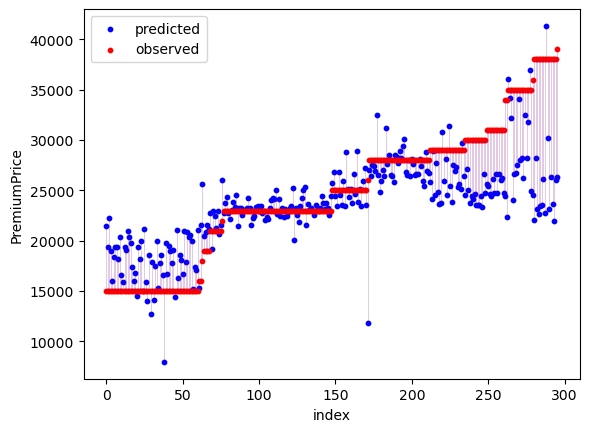

In [100]:
temp = pd.DataFrame({'Observed':y_test, 'predicted':pred})
temp.sort_values('Observed', inplace=True)
temp.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots()

ax.vlines(temp.index, temp.Observed, temp.Observed - (temp.Observed - temp.predicted), color='purple', linestyle='-', linewidth=0.5, alpha=0.3)

ax.scatter(temp.index, temp.predicted, color='blue', marker='o', label='predicted', s=10)
ax.scatter(temp.index, temp.Observed, color='red', marker='o', label='observed', s=10)

ax.set_xlabel('index')
ax.set_ylabel("PremiumPrice")
ax.legend()

plt.show()

In [ ]:
mape(y_test, pred)

In [102]:
summary.loc[len(summary.index)] = eval(svr, "SVM Regression")
summary

,model,test_rmse,train_rmse,test_mape,train_mape,cv_rmse,cv_rmse_std
0,random forset,2759.181478,2412.658707,6.283566,5.334523,3211.983204,603.617943
1,Decision tree,3663.197241,2498.912702,6.611471,4.647622,3476.864413,635.559543
2,SVM Regression,4644.401360,4309.564069,12.646112,11.210626,4466.945073,572.639107


# AdaBoost

In [463]:
from sklearn.ensemble import AdaBoostRegressor

In [464]:
X_train = pipe1.fit_transform(x_train.copy())
X_test = pipe1.fit_transform(x_test.copy())

In [465]:
param_grid = {
    'n_estimators': [100, 300, 500],
    'learning_rate':[0.0001, 0.001, 0.1, 1.0],
}

In [466]:
ada_boost = AdaBoostRegressor(random_state=42)

In [467]:
ada_grid = GridSearchCV(estimator = ada_boost, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [468]:
score = ada_grid.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


In [359]:
score.best_params_

{'learning_rate': 0.0001, 'n_estimators': 300}

In [469]:
Dtree = DecisionTreeRegressor(max_depth=6, random_state=42)
ada_boost = AdaBoostRegressor(n_estimators=300, base_estimator=Dtree, learning_rate=0.0001, random_state=42)

In [470]:
ada_boost

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=6,
                                                       random_state=42),
                  learning_rate=0.0001, n_estimators=300, random_state=42)

In [471]:
ada_boost.fit(X_train, y_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=6,
                                                       random_state=42),
                  learning_rate=0.0001, n_estimators=300, random_state=42)

In [472]:
pred = ada_boost.predict(X_test)

In [473]:
np.sqrt(mean_squared_error(y_test, pred))

2887.8418558540416

In [474]:
#train rmse
np.sqrt(mean_squared_error(y_train, ada_boost.predict(X_train)))

2170.852276795368

In [475]:
ada_trainf_r2=r2_score(y_train,ada_boost.predict(X_train))
ada_trainf_r2

0.8720534853659774

In [476]:
ada_testf_r2=r2_score(y_test,ada_boost.predict(X_test))
ada_testf_r2

0.809787124018683

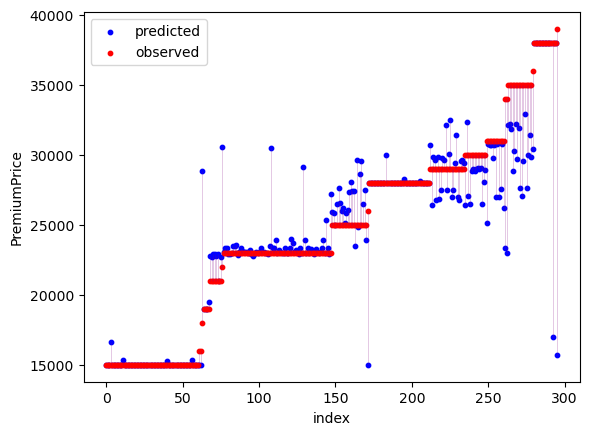

In [366]:
temp = pd.DataFrame({'Observed':y_test, 'predicted':pred})
temp.sort_values('Observed', inplace=True)
temp.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots()

ax.vlines(temp.index, temp.Observed, temp.Observed - (temp.Observed - temp.predicted), color='purple', linestyle='-', linewidth=0.5, alpha=0.3)

ax.scatter(temp.index, temp.predicted, color='blue', marker='o', label='predicted', s=10)
ax.scatter(temp.index, temp.Observed, color='red', marker='o', label='observed', s=10)

ax.set_xlabel('index')
ax.set_ylabel("PremiumPrice")
ax.legend()

plt.show()

### cv

In [112]:
cv = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(ada_boost, X_train, y_train, scoring='neg_mean_squared_error', cv=cv)
display_scores(np.sqrt(-scores))

Scores: [3592.16065306 3543.84695485 4099.6552954  2131.84860203 3304.76627416
 3484.00828493 3374.57624506 3201.80878288 3105.16632578 3714.13799221]
Mean: 3355.1975410354157
Standard deviation: 487.5380102310411


In [367]:
summary.loc[len(summary.index)] = eval(ada_boost, "AdaBoost")
summary

,model,test_rmse,train_rmse,test_mape,train_mape,cv_rmse,cv_rmse_std
0,XGBoost,2951.087455,2329.895080,7.398990,5.802680,3266.973937,579.040734
1,AdaBoost,2887.841856,2170.852277,4.238927,3.314714,3235.908079,573.944891


# XGBoost


In [477]:
import xgboost as xgb

In [478]:
X_train = pipe1.fit_transform(x_train.copy())
X_test = pipe1.fit_transform(x_test.copy())

In [250]:
param_grid = {
    'max_depth': [4, 5, 6],
    'colsample_bytree':[0.1,0.5,1],
    'eta':[0.1,0.01,0.05],
    'n_estimators': [100, 300, 500],
    'subsample':[0.5,1]
}

In [251]:
xg_boost = xgb.XGBRegressor(random_state=42)

In [254]:
xg_boost = GridSearchCV(estimator = xg_boost, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [255]:
score = xg_boost.fit(X_train, y_train)

Fitting 3 folds for each of 162 candidates, totalling 486 fits


In [256]:
score.best_estimator_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eta=0.01, eval_metric=None, feature_types=None, gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, ...)

In [257]:
score.best_params_

{'colsample_bytree': 1,
 'eta': 0.01,
 'max_depth': 4,
 'n_estimators': 500,
 'subsample': 0.5}

In [479]:
xg_boost = xgb.XGBRegressor(max_depth=4, random_state=42, colsample_bytree=1, subsample=0.5, eta=0.01,n_estimators=500)
#xg_boost = xgb.XGBRegressor(max_depth=5, gamma=0, subsample=0.9, eta=0.1,n_estimators=220)

In [480]:
xg_boost.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eta=0.01, eval_metric=None, feature_types=None, gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, ...)

In [481]:
pred = xg_boost.predict(X_test)

In [482]:
np.sqrt(mean_squared_error(y_test, pred))

2951.0874551298184

In [483]:
#train rmse
np.sqrt(mean_squared_error(y_train, xg_boost.predict(X_train)))

2329.895079968107

In [484]:
xg_boostf_r2=r2_score(y_train,xg_boost.predict(X_train))
xg_boostf_r2

0.8526192895689926

In [485]:
xg_boostt_r2=r2_score(y_test,xg_boost.predict(X_test))
xg_boostt_r2

0.8013643213082813

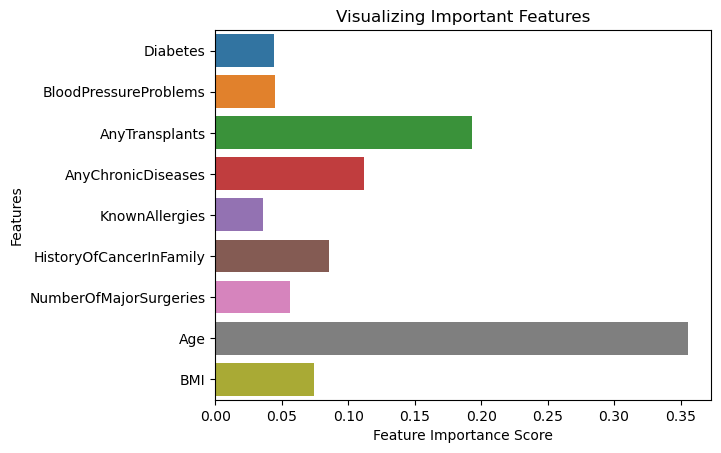

In [313]:
feature_imp1 = xg_boost.feature_importances_

sns.barplot(x=feature_imp1, y=X_train.columns)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

In [285]:
cv = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(xg_boost, X_train, y_train, 
                             scoring='neg_mean_squared_error',
                             cv=cv, n_jobs=-1)

In [286]:
display_scores(np.sqrt(-scores))

Scores: [3761.15081924 3307.30352064 4253.64923738 2461.47608765 3392.6021776
 3548.37208812 2471.60538555 2805.65341248 2816.60501784 3851.32162686]
Mean: 3266.973937334659
Standard deviation: 579.0407342492857


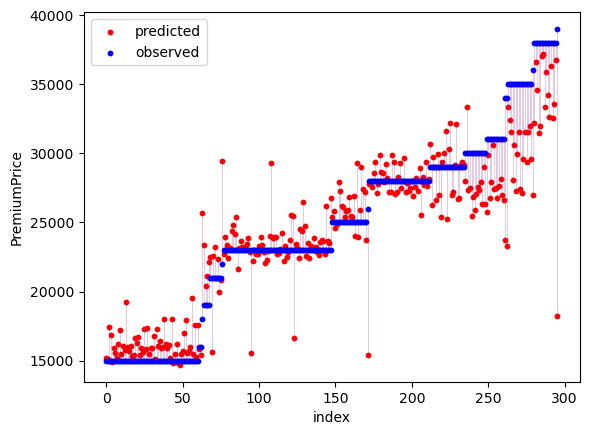

In [287]:
temp = pd.DataFrame({'Observed':y_test, 'predicted':pred})
temp.sort_values('Observed', inplace=True)
temp.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots()

ax.vlines(temp.index, temp.Observed, temp.Observed - (temp.Observed - temp.predicted), color='purple', linestyle='-', linewidth=0.5, alpha=0.3)

ax.scatter(temp.index, temp.predicted, color='red', marker='o', label='predicted', s=10)
ax.scatter(temp.index, temp.Observed, color='blue', marker='o', label='observed', s=10)

ax.set_xlabel('index')
ax.set_ylabel("PremiumPrice")
ax.legend()

plt.show()

In [289]:
train_sizes, train_scores, validation_scores = learning_curve(
estimator = xg_boost,
X = X_train,
y = y_train,
    cv = 5,
scoring = 'neg_mean_squared_error')

In [290]:
train_scores = np.sqrt(-train_scores)
validation_scores = np.sqrt(-validation_scores)

In [291]:
train_scores_mean = np.mean(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)

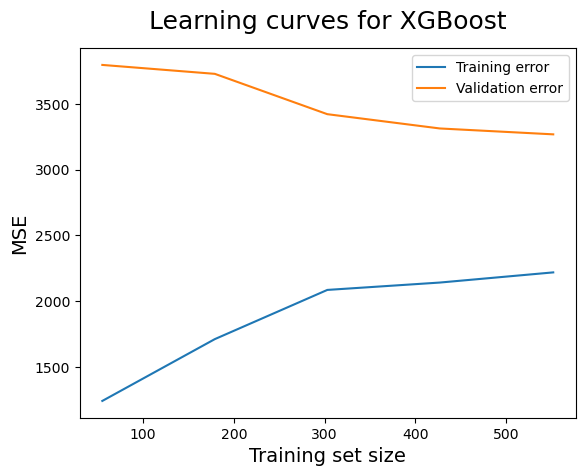

In [292]:
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for XGBoost', fontsize = 18, y = 1.03)
plt.legend()

In [273]:
summary.loc[len(summary.index)] = eval(xg_boost, "XGBoost")
summary

,model,test_rmse,train_rmse,test_mape,train_mape,cv_rmse,cv_rmse_std
0,XGBoost,2951.087455,2329.89508,7.39899,5.80268,3266.973937,579.040734


## Gradient Boosting

In [407]:
from sklearn.ensemble import GradientBoostingRegressor

In [408]:
param_grid = {
    'max_depth': [4, 5, 6],
    'learning_rate':[0.1,0.01,0.05],
    'n_estimators': [100, 300, 500],
}

In [409]:
X_train = pipe1.fit_transform(x_train.copy())
X_test = pipe1.fit_transform(x_test.copy())

In [410]:
gbm = GradientBoostingRegressor(random_state=42)

In [411]:
gbm_grid = GridSearchCV(estimator = gbm, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [412]:
score = gbm_grid.fit(X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


In [413]:
score.best_params_

{'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 300}

In [415]:
gbm = GradientBoostingRegressor(random_state=42, max_depth=4, n_estimators=300, learning_rate=0.01)

In [416]:
gbm.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.01, max_depth=4, n_estimators=300,
                          random_state=42)

In [417]:
pred = gbm.predict(X_test)

In [418]:
np.sqrt(mean_squared_error(y_test, pred))

2935.3128165685525

In [419]:
np.sqrt(mean_squared_error(y_train, gbm.predict(X_train)))

2581.817808533132

In [420]:
mape(y_test, pred)

MAPE for data: 0.08%


In [421]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [423]:
gbm_test_r2=r2_score(y_test,pred)
gbm_test_r2

0.8034822059764366

# Stacking

## attempt1

In [324]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV

In [331]:
from sklearn.model_selection import RepeatedKFold

In [42]:
def get_models():
 models = dict()
 models['knn'] = KNeighborsRegressor()
 models['cart'] = DecisionTreeRegressor()
 models['svm'] = SVR()
 return models

In [329]:
def evaluate_model(model, X, y):
 cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
 scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')
 return np.sqrt(-scores)

In [44]:
models = get_models()

>knn 4078.646 (530.102)
>cart 3621.613 (747.872)
>svm 6072.075 (303.383)


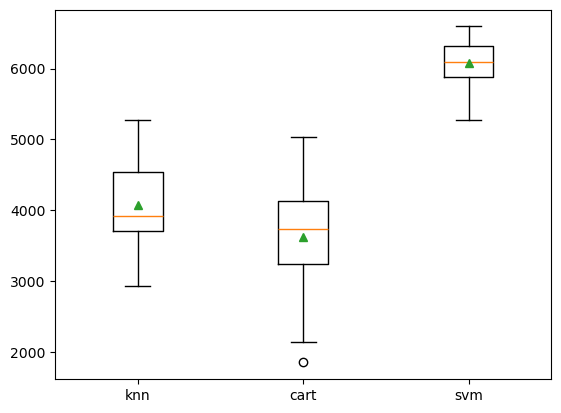

In [45]:
results, names = list(), list()
for name, model in models.items():
 scores = evaluate_model(model, X, y)
 results.append(scores)
 names.append(name)
 print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

In [46]:
def get_models():
 models = dict()
 models['knn'] = KNeighborsRegressor()
 models['cart'] = DecisionTreeRegressor()
 models['svm'] = SVR()
 models['stacking'] = get_stacking()
 return models

In [47]:
def get_stacking():
 # define the base models
 level0 = list()
 level0.append(('knn', KNeighborsRegressor()))
 level0.append(('cart', DecisionTreeRegressor()))
 level0.append(('svm', SVR()))
 # define meta learner model
 level1 = LinearRegression()
 # define the stacking ensemble
 model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
 return model

>knn 3598.646 (584.754)
>cart 3440.372 (868.422)
>svm 5988.586 (433.514)
>stacking 3146.628 (622.795)


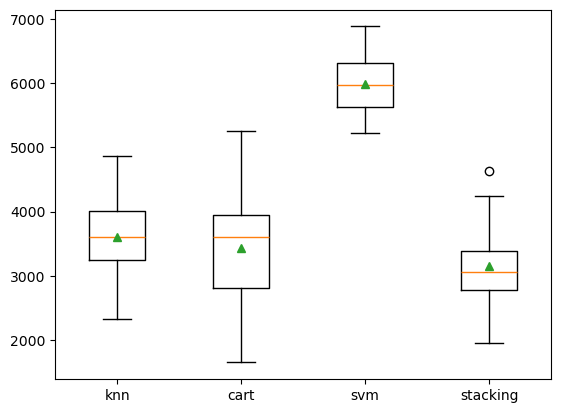

In [53]:
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
 scores = evaluate_model(model, X_train, y_train)
 results.append(scores)
 names.append(name)
 print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

## attempt2

In [341]:
level0 = list()
level0.append(('forest', RandomForestRegressor(random_state=42, max_depth=6, n_estimators=300, n_jobs=-1, min_samples_leaf=2)))
level0.append(('xgboost', xgb.XGBRegressor(max_depth=4, random_state=42, colsample_bytree=1, subsample=0.5, eta=0.01,n_estimators=500)))

level1 = LinearRegression()

stacked_model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)


# level0 = list()
# level0.append(('forest', RandomForestRegressor(random_state=42, max_depth=6, n_estimators=300, n_jobs=-1, min_samples_leaf=2)))
# level0.append(('adaBoost', AdaBoostRegressor(n_estimators=100, base_estimator=Dtree, learning_rate=0.0001, random_state=42)))

# level1 = LinearRegression()

# stacked_model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)

In [342]:
models = dict()
models["forest"] = RandomForestRegressor(random_state=42)
models["xgboost"] = xgb.XGBRegressor()
models["stacking"] = stacked_model

# models = dict()
# models["forest"] = RandomForestRegressor(random_state=42)
# models["adaBoost"] = AdaBoostRegressor()
# models["stacking"] = stacked_model

In [343]:
models

{'forest': RandomForestRegressor(random_state=42),
 'xgboost': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...),
 'stacking': StackingRegressor(cv=5,
                   estimators=[('forest',
                                RandomForestRegressor(max_depth=6,
                                 

>forest 3410.852 (732.343)
>xgboost 3784.422 (713.624)
>stacking 3197.344 (770.594)


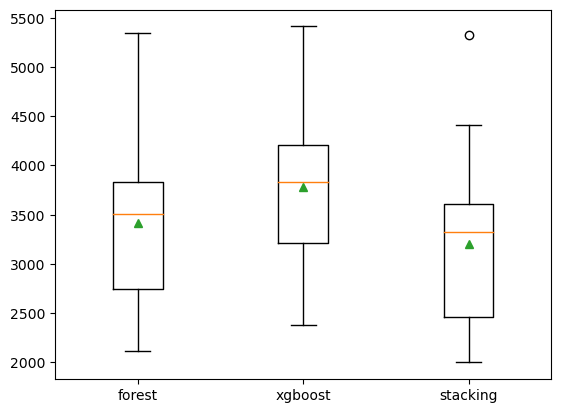

In [344]:
results, names = list(), list()
for name, model in models.items():
 scores = evaluate_model(model, X_train, y_train)
 results.append(scores)
 names.append(name)
 print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

## Isolation forecast

In [88]:
y_train

398    28000
523    23000
809    35000
501    19000
430    25000
       ...  
106    25000
270    25000
860    28000
435    31000
102    31000
Name: PremiumPrice, Length: 690, dtype: int64

In [103]:
dataNew=df.drop(["Height","Weight"],axis=1)
dataNew

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,PremiumPrice
0,45,0,0,0,0,0,0,0,25000
1,60,1,0,0,0,0,0,0,29000
2,36,1,1,0,0,0,0,1,23000
3,52,1,1,0,1,0,0,2,28000
4,38,0,0,0,1,0,0,1,23000
...,...,...,...,...,...,...,...,...,...
981,18,0,0,0,0,0,0,0,15000
982,64,1,1,0,0,0,0,3,28000
983,56,0,1,0,0,0,0,1,29000
984,47,1,1,0,0,1,0,1,39000


In [105]:
from sklearn.ensemble import IsolationForest
model=IsolationForest(n_estimators=50, max_samples='auto', contamination=float(0.1),max_features=1.0)



In [106]:
X_train = pipe1.fit_transform(x_train.copy())
X_test = pipe1.fit_transform(x_test.copy())

In [107]:
model.fit(X_train, y_train)

IsolationForest(contamination=0.1, n_estimators=50)

In [117]:
train_anomaly_scores = model.decision_function(X_train)
test_anomaly_scores = model.decision_function(X_test)

In [132]:
Ytrain_anomaly_scores = model.decision_function(y_train)

ValueError: Expected 2D array, got 1D array instead:
array=[28000. 23000. 35000. 19000. 25000. 39000. 15000. 15000. 15000. 24000.
 38000. 28000. 15000. 31000. 28000. 23000. 23000. 31000. 15000. 29000.
 24000. 15000. 15000. 25000. 25000. 15000. 23000. 28000. 23000. 23000.
 30000. 25000. 38000. 29000. 30000. 23000. 25000. 31000. 23000. 28000.
 25000. 21000. 15000. 28000. 15000. 15000. 23000. 28000. 30000. 15000.
 15000. 29000. 15000. 23000. 30000. 23000. 23000. 30000. 38000. 15000.
 31000. 38000. 21000. 28000. 15000. 38000. 31000. 29000. 28000. 29000.
 21000. 21000. 28000. 15000. 25000. 23000. 39000. 38000. 30000. 28000.
 29000. 19000. 28000. 29000. 25000. 28000. 27000. 15000. 35000. 15000.
 23000. 28000. 25000. 23000. 25000. 28000. 15000. 38000. 28000. 23000.
 15000. 15000. 29000. 25000. 28000. 15000. 25000. 15000. 15000. 23000.
 15000. 28000. 23000. 25000. 35000. 30000. 23000. 31000. 23000. 29000.
 23000. 15000. 23000. 23000. 31000. 23000. 15000. 25000. 15000. 23000.
 25000. 29000. 23000. 23000. 23000. 29000. 23000. 29000. 15000. 29000.
 25000. 19000. 23000. 23000. 23000. 28000. 28000. 23000. 25000. 23000.
 25000. 15000. 23000. 23000. 29000. 23000. 31000. 15000. 21000. 15000.
 25000. 25000. 23000. 29000. 28000. 23000. 28000. 25000. 38000. 28000.
 29000. 15000. 31000. 15000. 21000. 15000. 30000. 15000. 15000. 15000.
 23000. 18000. 15000. 15000. 15000. 32000. 23000. 21000. 29000. 30000.
 23000. 35000. 23000. 19000. 15000. 36000. 28000. 15000. 23000. 28000.
 15000. 15000. 15000. 15000. 23000. 28000. 29000. 29000. 35000. 28000.
 38000. 25000. 26000. 23000. 23000. 15000. 32000. 23000. 28000. 15000.
 30000. 23000. 29000. 31000. 26000. 31000. 28000. 28000. 23000. 25000.
 28000. 23000. 20000. 23000. 28000. 23000. 16000. 23000. 28000. 23000.
 23000. 25000. 28000. 15000. 15000. 25000. 30000. 28000. 25000. 15000.
 28000. 15000. 23000. 38000. 30000. 32000. 28000. 15000. 15000. 15000.
 23000. 23000. 23000. 30000. 15000. 23000. 38000. 25000. 23000. 30000.
 23000. 15000. 23000. 21000. 23000. 23000. 15000. 19000. 15000. 19000.
 23000. 15000. 23000. 19000. 38000. 30000. 35000. 28000. 25000. 25000.
 23000. 23000. 15000. 25000. 29000. 28000. 35000. 23000. 31000. 23000.
 23000. 21000. 28000. 23000. 19000. 23000. 23000. 15000. 21000. 23000.
 28000. 23000. 23000. 29000. 23000. 23000. 15000. 15000. 25000. 23000.
 30000. 23000. 25000. 15000. 15000. 23000. 35000. 15000. 35000. 35000.
 39000. 35000. 15000. 28000. 23000. 25000. 23000. 28000. 25000. 15000.
 15000. 30000. 28000. 28000. 30000. 25000. 31000. 28000. 15000. 28000.
 25000. 28000. 23000. 28000. 23000. 25000. 29000. 23000. 29000. 15000.
 23000. 28000. 28000. 15000. 23000. 23000. 15000. 15000. 25000. 21000.
 32000. 35000. 29000. 25000. 15000. 35000. 31000. 15000. 23000. 23000.
 23000. 28000. 25000. 35000. 31000. 28000. 38000. 23000. 15000. 23000.
 25000. 15000. 25000. 23000. 28000. 23000. 23000. 15000. 28000. 23000.
 25000. 38000. 23000. 23000. 28000. 25000. 25000. 25000. 28000. 15000.
 15000. 15000. 39000. 29000. 21000. 23000. 23000. 29000. 29000. 23000.
 21000. 23000. 23000. 26000. 15000. 15000. 23000. 30000. 23000. 23000.
 29000. 15000. 30000. 25000. 25000. 15000. 23000. 26000. 23000. 15000.
 15000. 23000. 23000. 38000. 25000. 15000. 19000. 15000. 29000. 23000.
 19000. 25000. 25000. 15000. 23000. 28000. 23000. 23000. 23000. 28000.
 23000. 23000. 21000. 35000. 15000. 29000. 28000. 28000. 30000. 23000.
 30000. 35000. 15000. 31000. 30000. 28000. 23000. 25000. 23000. 23000.
 15000. 23000. 23000. 23000. 23000. 15000. 15000. 23000. 28000. 30000.
 29000. 15000. 26000. 25000. 23000. 25000. 15000. 29000. 25000. 15000.
 28000. 29000. 30000. 23000. 25000. 15000. 15000. 23000. 28000. 15000.
 30000. 35000. 29000. 28000. 29000. 15000. 29000. 35000. 23000. 23000.
 23000. 21000. 29000. 15000. 24000. 23000. 21000. 23000. 15000. 15000.
 19000. 23000. 25000. 38000. 25000. 38000. 25000. 15000. 23000. 28000.
 35000. 15000. 25000. 28000. 23000. 23000. 28000. 25000. 25000. 21000.
 23000. 29000. 25000. 23000. 23000. 23000. 23000. 28000. 29000. 15000.
 25000. 15000. 29000. 23000. 15000. 23000. 25000. 28000. 35000. 15000.
 25000. 15000. 15000. 23000. 15000. 23000. 28000. 29000. 28000. 28000.
 30000. 25000. 23000. 40000. 28000. 25000. 28000. 25000. 15000. 28000.
 23000. 30000. 29000. 23000. 15000. 26000. 28000. 28000. 15000. 15000.
 28000. 30000. 23000. 28000. 23000. 29000. 15000. 15000. 23000. 23000.
 35000. 28000. 28000. 29000. 25000. 23000. 23000. 28000. 25000. 28000.
 23000. 30000. 30000. 15000. 35000. 23000. 15000. 31000. 23000. 15000.
 23000. 17000. 29000. 28000. 25000. 35000. 38000. 21000. 28000. 15000.
 25000. 23000. 23000. 23000. 15000. 25000. 23000. 23000. 15000. 24000.
 25000. 23000. 15000. 23000. 23000. 15000. 23000. 38000. 35000. 15000.
 15000. 35000. 29000. 15000. 23000. 25000. 15000. 25000. 28000. 15000.
 15000. 25000. 15000. 23000. 15000. 15000. 28000. 23000. 28000. 23000.
 29000. 29000. 28000. 30000. 30000. 25000. 25000. 28000. 31000. 31000.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
train_df_with_scores = pd.DataFrame(np.column_stack([X_train, train_anomaly_scores]), columns=list(X_train.columns) + ['Anomaly_Score'])
test_df_with_scores = pd.DataFrame(np.column_stack([X_test, test_anomaly_scores]), columns=list(X_test.columns) + ['Anomaly_Score'])

In [120]:
train_df_with_scores

,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,Age,BMI,Anomaly_Score
0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,1.744038,-0.191539,0.125689
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.474779,0.449909,0.153702
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.455692,1.564087,0.035674
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,-1.118952,-1.006804,0.041837
4,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.171440,-0.502022,0.141866
...,...,...,...,...,...,...,...,...,...,...
685,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.314589,-0.567254,0.131299
686,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.312543,-1.094363,0.047473
687,1.0,0.0,0.0,0.0,0.0,0.0,3.0,1.386164,-0.342255,-0.003759
688,1.0,0.0,0.0,0.0,1.0,1.0,1.0,-0.331630,-1.135170,-0.013120


In [121]:
test_df_with_scores

,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,Age,BMI,Anomaly_Score
0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.574332,0.579845,0.017676
1,0.0,0.0,0.0,1.0,1.0,1.0,1.0,-0.216042,-1.036740,-0.046512
2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.652114,0.766873,0.113681
3,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.934563,-0.948894,0.037676
4,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.430627,0.218798,0.043695
...,...,...,...,...,...,...,...,...,...,...
291,0.0,1.0,0.0,0.0,0.0,0.0,2.0,1.221001,-0.776559,0.111562
292,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.437529,0.271405,0.128199
293,1.0,1.0,0.0,0.0,0.0,0.0,1.0,-0.000485,-1.428812,0.109425
294,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.790859,0.455164,0.154532


In [131]:
anomaly = train_df_with_scores[train_df_with_scores['Anomaly_Score'] <= 0].reset_index(drop=True)

anomaly_index=list(anomaly.index)
print(anomaly_index)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68]


In [133]:
outliers_counter = len(y_train[y_train['PremiumPrice'] > 99999])
outliers_counter

KeyError: 'PremiumPrice'

# Cluster wise model fitting

In [26]:
dq = pd.read_csv("data.csv")

In [27]:
dq.drop(["BMI", "BMI_cat"], axis=1, inplace=True)

In [28]:
cluster1 = dq[dq.cluster == 1]
cluster2 = dq[dq.cluster == 2]
cluster3 = dq[dq.cluster == 3]

## cluster1

3528.449786341991
895.4240395065992


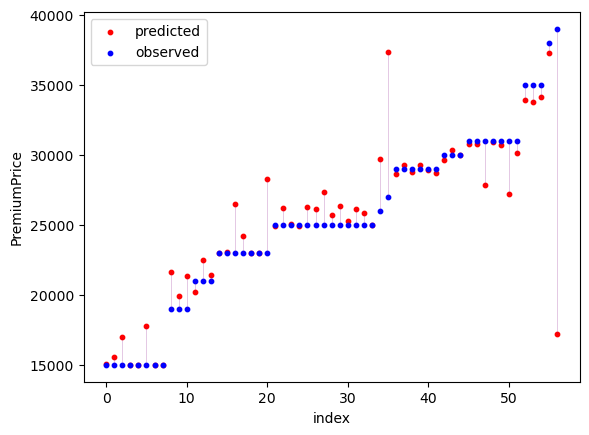

In [74]:
X_c1 = cluster1.drop("PremiumPrice", axis=1)
y_c1 = cluster1.PremiumPrice
X_c1_train, X_c1_test, y_c1_train, y_c1_test = train_test_split(X_c1, y_c1, test_size=0.2, random_state=42)

forest_reg = RandomForestRegressor(random_state=42)

forest_reg.fit(X_c1_train, y_c1_train)

pred_c1_test = forest_reg.predict(X_c1_test)

print(np.sqrt(mean_squared_error(y_c1_test, pred_c1_test)))

#train rmse
pred_c1_train = forest_reg.predict(X_c1_train)
print(np.sqrt(mean_squared_error(y_c1_train, pred_c1_train)))


temp = pd.DataFrame({'Observed':y_c1_test, 'predicted':pred_c1_test})
temp.sort_values('Observed', inplace=True)
temp.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots()

ax.vlines(temp.index, temp.Observed, temp.Observed - (temp.Observed - temp.predicted), color='purple', linestyle='-', linewidth=0.5, alpha=0.3)

ax.scatter(temp.index, temp.predicted, color='red', marker='o', label='predicted', s=10)
ax.scatter(temp.index, temp.Observed, color='blue', marker='o', label='observed', s=10)

ax.set_xlabel('index')
ax.set_ylabel("PremiumPrice")
ax.legend()

plt.show()

### cv

In [75]:
scores = cross_val_score(forest_reg, X_c1_train, y_c1_train, scoring="neg_mean_squared_error", cv=10)

scores = np.sqrt(-scores)

display_scores(scores)

Scores: [3231.63035984 3022.75788269 2224.49505751 1340.55634136 3031.35139902
 3424.72340997 1308.46408467 1185.08117499 1931.15250563 2484.88979086]
Mean: 2318.5102006526
Standard deviation: 806.8096878414024


## cluster2

4989.134729242603
929.0640451551228


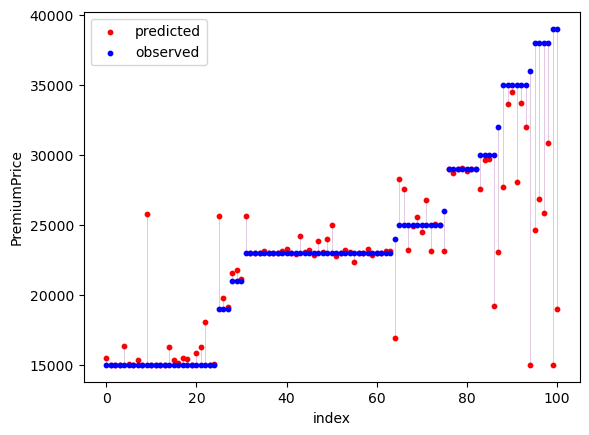

In [76]:
X_c2 = cluster2.drop("PremiumPrice", axis=1)
y_c2 = cluster2.PremiumPrice
X_c2_train, X_c2_test, y_c2_train, y_c2_test = train_test_split(X_c2, y_c2, test_size=0.2, random_state=42)

forest_reg = RandomForestRegressor(random_state=42)

forest_reg.fit(X_c2_train, y_c2_train)

pred_c2_test = forest_reg.predict(X_c2_test)

print(np.sqrt(mean_squared_error(y_c2_test, pred_c2_test)))

#train rmse
pred_c2_train = forest_reg.predict(X_c2_train)
print(np.sqrt(mean_squared_error(y_c2_train, pred_c2_train)))

temp = pd.DataFrame({'Observed':y_c2_test, 'predicted':pred_c2_test})
temp.sort_values('Observed', inplace=True)
temp.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots()

ax.vlines(temp.index, temp.Observed, temp.Observed - (temp.Observed - temp.predicted), color='purple', linestyle='-', linewidth=0.5, alpha=0.3)

ax.scatter(temp.index, temp.predicted, color='red', marker='o', label='predicted', s=10)
ax.scatter(temp.index, temp.Observed, color='blue', marker='o', label='observed', s=10)

ax.set_xlabel('index')
ax.set_ylabel("PremiumPrice")
ax.legend()

plt.show()

### cv

In [77]:
scores = cross_val_score(forest_reg, X_c2_train, y_c2_train, scoring="neg_mean_squared_error", cv=10)

scores = np.sqrt(-scores)

display_scores(scores)

Scores: [2543.81603108 3987.41990515 1823.00164564 2171.16731276 3897.96357089
 1081.65729323 4017.35671804 3378.48264758 3458.47654322 2332.75748847]
Mean: 2869.2099156066834
Standard deviation: 969.762063696187


## cluster3

1610.9554618300283
766.6648550703234


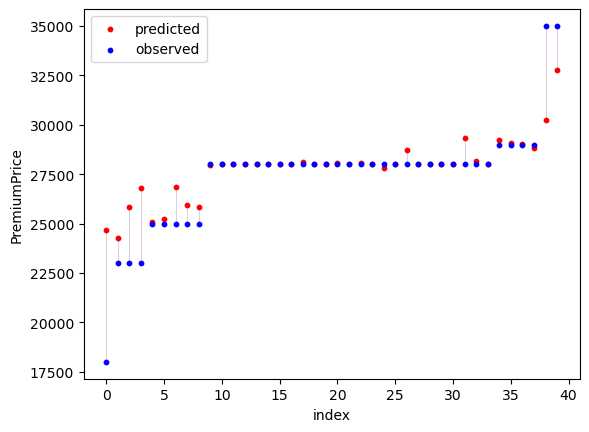

In [78]:
X_c3 = cluster3.drop("PremiumPrice", axis=1)
y_c3 = cluster3.PremiumPrice
X_c3_train, X_c3_test, y_c3_train, y_c3_test = train_test_split(X_c3, y_c3, test_size=0.2, random_state=42)

forest_reg = RandomForestRegressor(random_state=42)

forest_reg.fit(X_c3_train, y_c3_train)

pred_c3_test = forest_reg.predict(X_c3_test)

print(np.sqrt(mean_squared_error(y_c3_test, pred_c3_test)))

# train rmse
pred_c3_train = forest_reg.predict(X_c3_train)
print(np.sqrt(mean_squared_error(y_c3_train, pred_c3_train)))

temp = pd.DataFrame({'Observed':y_c3_test, 'predicted':pred_c3_test})
temp.sort_values('Observed', inplace=True)
temp.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots()

ax.vlines(temp.index, temp.Observed, temp.Observed - (temp.Observed - temp.predicted), color='purple', linestyle='-', linewidth=0.5, alpha=0.3)

ax.scatter(temp.index, temp.predicted, color='red', marker='o', label='predicted', s=10)
ax.scatter(temp.index, temp.Observed, color='blue', marker='o', label='observed', s=10)

ax.set_xlabel('index')
ax.set_ylabel("PremiumPrice")
ax.legend()

plt.show()

### cv

In [79]:
scores = cross_val_score(forest_reg, X_c3_train, y_c3_train, scoring="neg_mean_squared_error", cv=10)

scores = np.sqrt(-scores)

display_scores(scores)

Scores: [ 260.43233286 2563.38033659 1562.74998    1402.98565566 2599.50956913
 1932.68272099 1953.8871513  1533.95730058 3211.49303284 1033.55273208]
Mean: 1805.4630812036557
Standard deviation: 806.0807573752162


In [80]:
y_c1_test.shape + y_c2_test.shape + y_c3_test.shape

(57, 101, 40)

In [81]:
dfc1 = pd.DataFrame({'test_observed':y_c1_test,
              'test_predicted':pred_c1_test})
dfc1.reset_index(drop=True, inplace=True)

dfc2 = pd.DataFrame({'test_observed':y_c2_test,
              'test_predicted':pred_c2_test})
dfc2.reset_index(drop=True, inplace=True)

dfc3 = pd.DataFrame({'test_observed':y_c3_test,
              'test_predicted':pred_c3_test})
dfc3.reset_index(drop=True, inplace=True)

dfc = pd.concat([dfc1, dfc2, dfc3])

In [82]:
np.sqrt(mean_squared_error(dfc.test_observed, dfc.test_predicted))

4099.453461971326

# Adding cluster label

In [83]:
dp = upsample().fit_transform(dq.copy())

In [84]:
X = dp.drop("PremiumPrice", axis=1)
y = dp.PremiumPrice.copy()

In [85]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [86]:
X_train = pipe.fit_transform(x_train.copy())
X_test = pipe.fit_transform(x_test.copy())

## Random Forest

In [87]:
forest_reg = RandomForestRegressor(random_state=42)

In [88]:
forest_reg.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [89]:
pred = forest_reg.predict(X_test)

In [90]:
np.sqrt(mean_squared_error(y_test, pred))

3761.327502284167

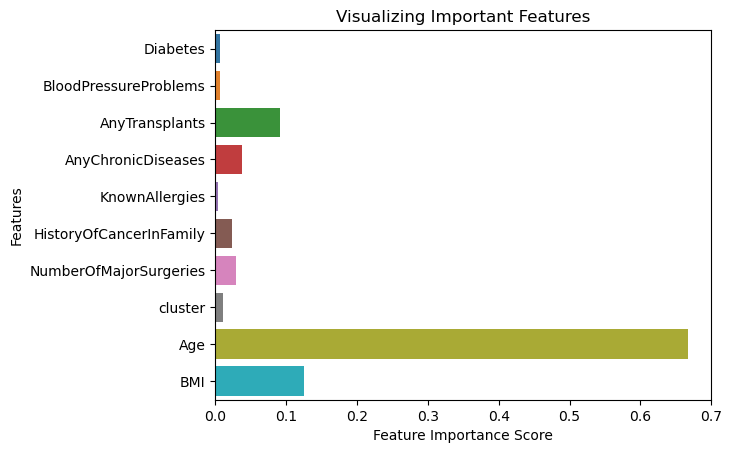

In [91]:
feature_imp1 = forest_reg.feature_importances_

sns.barplot(x=feature_imp1, y=X_train.columns)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

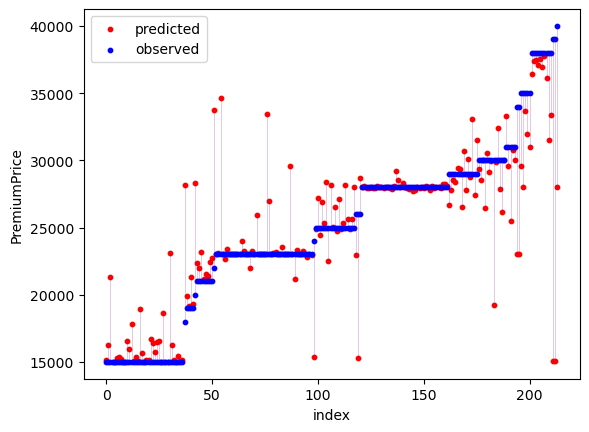

In [92]:
temp = pd.DataFrame({'Observed':y_test, 'predicted':pred})
temp.sort_values('Observed', inplace=True)
temp.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots()

ax.vlines(temp.index, temp.Observed, temp.Observed - (temp.Observed - temp.predicted), color='purple', linestyle='-', linewidth=0.5, alpha=0.3)

ax.scatter(temp.index, temp.predicted, color='red', marker='o', label='predicted', s=10)
ax.scatter(temp.index, temp.Observed, color='blue', marker='o', label='observed', s=10)

ax.set_xlabel('index')
ax.set_ylabel("PremiumPrice")
ax.legend()

plt.show()

### cross validation

In [93]:
scores = cross_val_score(forest_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=10)

scores = np.sqrt(-scores)

display_scores(scores)

Scores: [3274.24250071 1849.36381267 1775.84012218 3059.57475385 2268.62267405
 3867.35276925 2859.97326191 2546.95527571 1961.94351421 3697.32876547]
Mean: 2716.1197450022637
Standard deviation: 719.1181025717005


## xgboost

In [108]:
xgb_reg = xgb.XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1,
                         subsample=0.7, colsample_bytree=0.8)

In [109]:
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

In [110]:
pred = xgb_reg.predict(X_test)

In [111]:
np.sqrt(mean_squared_error(y_test, pred))

3711.374125298774

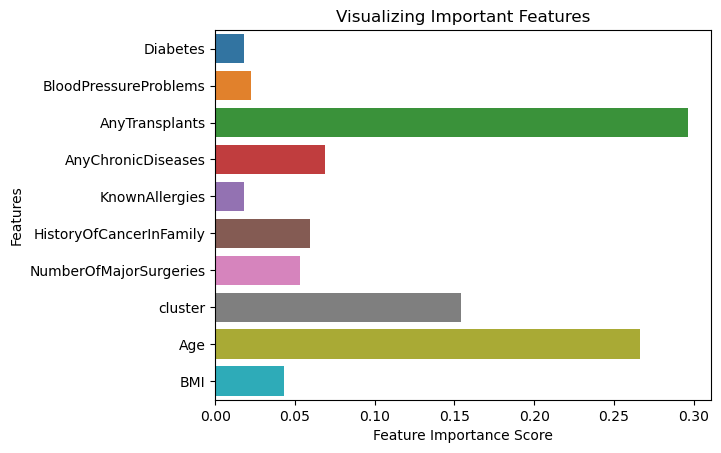

In [112]:
feature_imp1 = xgb_reg.feature_importances_

sns.barplot(x=feature_imp1, y=X_train.columns)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

### cross vaidation

In [113]:
scores = cross_val_score(model, X_train, y_train,
                         scoring="neg_mean_squared_error", cv=10)

In [114]:
scores = np.sqrt(-scores)

In [115]:
display_scores(scores)

Scores: [3722.37943274 2340.43957688 1556.18977672 3403.55792529 2712.61894467
 3969.14128059 2537.18222602 2625.41695922 2120.0744036  3542.41159642]
Mean: 2852.9412122152635
Standard deviation: 737.0787556316893


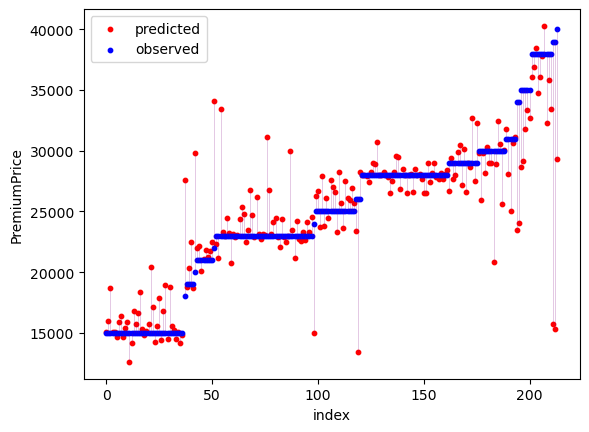

In [116]:
temp = pd.DataFrame({'Observed':y_test, 'predicted':pred})
temp.sort_values('Observed', inplace=True)
temp.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots()

ax.vlines(temp.index, temp.Observed, temp.Observed - (temp.Observed - temp.predicted), color='purple', linestyle='-', linewidth=0.5, alpha=0.3)

ax.scatter(temp.index, temp.predicted, color='red', marker='o', label='predicted', s=10)
ax.scatter(temp.index, temp.Observed, color='blue', marker='o', label='observed', s=10)

ax.set_xlabel('index')
ax.set_ylabel("PremiumPrice")
ax.legend()

plt.show()

# Factor Analysis Components Regression

In [101]:
fct = pd.read_csv("factor.csv")

In [102]:
X = fct.copy()

In [103]:
y = df.PremiumPrice.copy()

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

## Random forest

In [105]:
forest_reg = RandomForestRegressor()

In [106]:
forest_reg.fit(X_train, y_train)

RandomForestRegressor()

In [107]:
pred = forest_reg.predict(X_test)

In [108]:
np.sqrt(mean_squared_error(y_test, pred))

3486.747203427008

In [109]:
scores = cross_val_score(forest_reg, X_train, y_train, scoring='neg_mean_squared_error', cv=10)

In [110]:
scores = np.sqrt(-scores)

In [111]:
display_scores(scores)

Scores: [4199.09061885 3812.35632641 3556.15921388 4153.50103961 3596.28394706
 4207.78106833 4154.22661084 3569.86862858 2805.78111981 3928.45405752]
Mean: 3798.3502630881585
Standard deviation: 416.5350279371173


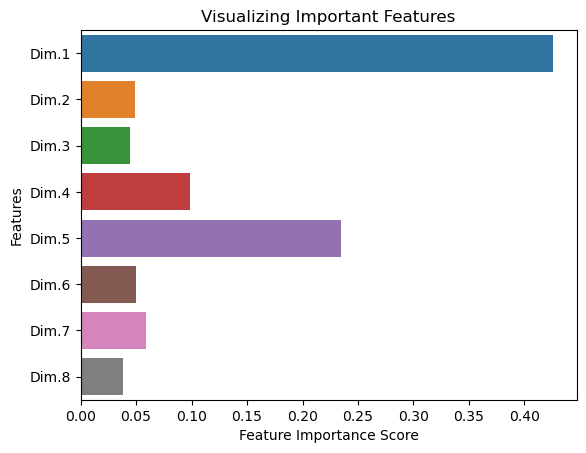

In [112]:
feature_imp1 = forest_reg.feature_importances_

sns.barplot(x=feature_imp1, y=X_train.columns)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

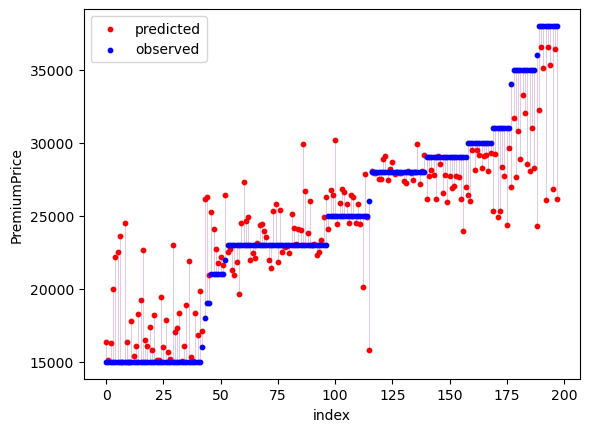

In [113]:
temp = pd.DataFrame({'Observed':y_test, 'predicted':pred})
temp.sort_values('Observed', inplace=True)
temp.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots()

ax.vlines(temp.index, temp.Observed, temp.Observed - (temp.Observed - temp.predicted), color='purple', linestyle='-', linewidth=0.5, alpha=0.3)

ax.scatter(temp.index, temp.predicted, color='red', marker='o', label='predicted', s=10)
ax.scatter(temp.index, temp.Observed, color='blue', marker='o', label='observed', s=10)

ax.set_xlabel('index')
ax.set_ylabel("PremiumPrice")
ax.legend()

plt.show()

## XGBoost

In [114]:
xgb_reg = xgb.XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1,
                         subsample=0.7, colsample_bytree=0.8)

In [115]:
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

In [116]:
pred = xgb_reg.predict(X_test)

In [117]:
np.sqrt(mean_squared_error(y_test, pred))

3514.1452270275063

In [118]:
scores = cross_val_score(xgb_reg, X_train, y_train, scoring='neg_mean_squared_error', cv=10)

In [119]:
scores = np.sqrt(-scores)

In [120]:
display_scores(scores)

Scores: [4662.22691682 3893.09128372 4118.28264508 4105.64214189 3601.5863421
 4378.97024244 4203.16461578 3637.87452119 3081.34424207 3960.65136234]
Mean: 3964.283431343744
Standard deviation: 422.2093798464794


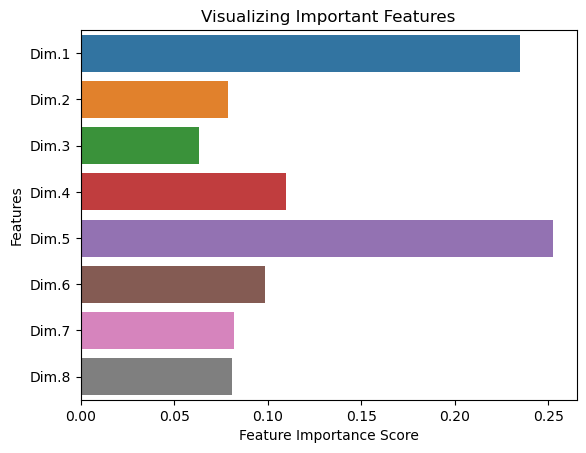

In [121]:
feature_imp1 = xgb_reg.feature_importances_

sns.barplot(x=feature_imp1, y=X_train.columns)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

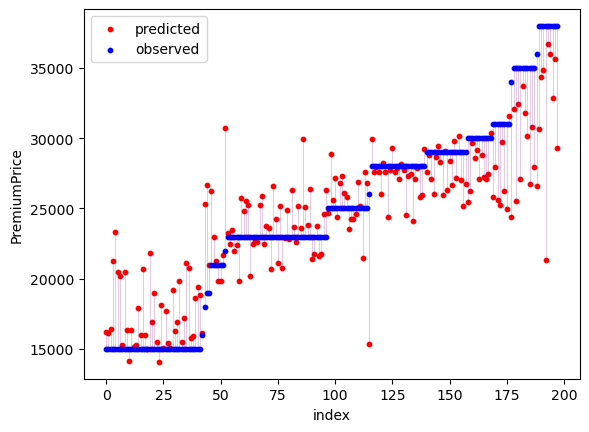

In [122]:
temp = pd.DataFrame({'Observed':y_test, 'predicted':pred})
temp.sort_values('Observed', inplace=True)
temp.reset_index(drop=True, inplace=True)

fig, ax = plt.subplots()

ax.vlines(temp.index, temp.Observed, temp.Observed - (temp.Observed - temp.predicted), color='purple', linestyle='-', linewidth=0.5, alpha=0.3)

ax.scatter(temp.index, temp.predicted, color='red', marker='o', label='predicted', s=10)
ax.scatter(temp.index, temp.Observed, color='blue', marker='o', label='observed', s=10)

ax.set_xlabel('index')
ax.set_ylabel("PremiumPrice")
ax.legend()

plt.show()

# experiment

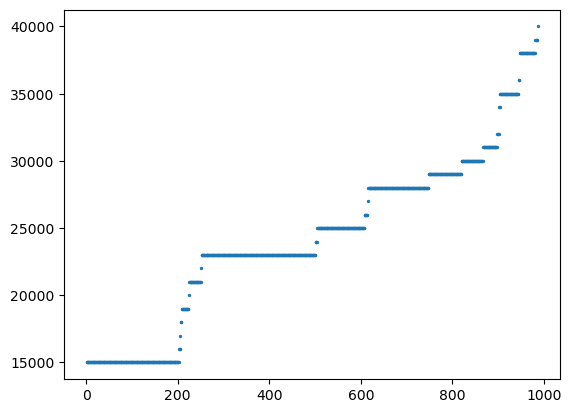

In [137]:
temp = dq.PremiumPrice.sort_values()
plt.scatter(np.arange(1, len(temp) + 1, 1), temp, s=2)

In [138]:
np.unique(df.PremiumPrice)

array([15000, 16000, 17000, 18000, 19000, 20000, 21000, 22000, 23000,
       24000, 25000, 26000, 27000, 28000, 29000, 30000, 31000, 32000,
       34000, 35000, 36000, 38000, 39000, 40000], dtype=int64)

In [139]:
len(np.unique(df.PremiumPrice))

24

In [134]:
def outlierDetection(column_name, tbl):
    Q1 = tbl[column_name].quantile(0.25)
    Q3 = tbl[column_name].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = (tbl[column_name] < lower_bound) | (tbl[column_name] > upper_bound)
    outlier_indices = tbl.index[outliers]
    return outlier_indices

In [140]:
dt

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,PremiumPrice
0,45,0,0,0,0,155,57,0,0,0,25000
1,60,1,0,0,0,180,73,0,0,0,29000
2,36,1,1,0,0,158,59,0,0,1,23000
3,52,1,1,0,1,183,93,0,0,2,28000
4,38,0,0,0,1,166,88,0,0,1,23000
...,...,...,...,...,...,...,...,...,...,...,...
981,18,0,0,0,0,169,67,0,0,0,15000
982,64,1,1,0,0,153,70,0,0,3,28000
983,56,0,1,0,0,155,71,0,0,1,29000
984,47,1,1,0,0,158,73,1,0,1,39000


In [141]:
def find_outlier_rows(df, col, level='both'):
    # compute the interquartile range
    iqr = df[col].quantile(0.75) - df[col].quantile(0.25)

    # compute the upper and lower bounds for identifying outliers
    lower_bound = df[col].quantile(0.25) - 1.5 * iqr
    upper_bound = df[col].quantile(0.75) + 1.5 * iqr

    # filter the rows based on the level of outliers to return
    if level == 'lower':
        return df[df[col] < lower_bound]
    elif level == 'upper':
        return df[df[col] > upper_bound]
    else:
        return df[(df[col] > upper_bound) | (df[col] < lower_bound)]
def count_outliers(df):
    # select numeric columns
    df_numeric = df.select_dtypes(include=['int', 'float'])

    # get column names
    columns = df_numeric.columns

    # find the name of all columns with outliers
    outlier_cols = [col for col in columns if len(find_outlier_rows(df_numeric, col)) != 0]

    # dataframe to store the results
    outliers_df = pd.DataFrame(columns=['outlier_counts', 'outlier_percent'])

    # count the outliers and compute the percentage of outliers for each column
    for col in outlier_cols:
        outlier_count = len(find_outlier_rows(df_numeric, col))
        all_entries = len(df[col])
        outlier_percent = round(outlier_count * 100 / all_entries, 2)

        # store the results in the dataframe
        outliers_df.loc[col] = [outlier_count, outlier_percent]

    # return the resulting dataframe
    return outliers_df

In [142]:
cols_to_exclude = ['Height', 'Weight']
count_outliers(dt.drop(cols_to_exclude,axis=1))

,outlier_counts,outlier_percent
AnyTransplants,55.0,5.58
AnyChronicDiseases,178.0,18.05
KnownAllergies,212.0,21.50
HistoryOfCancerInFamily,116.0,11.76
NumberOfMajorSurgeries,16.0,1.62
PremiumPrice,6.0,0.61


In [164]:
outlierDetection('PremiumPrice', dt)

Index([  7,  12,  14,  19,  21,  26,  30,  32,  33,  38,
       ...
       949, 953, 956, 958, 961, 964, 965, 966, 968, 969],
      dtype='int64', length=244)

In [156]:
outlierDetection('Age', df)

Index([], dtype='int64')

In [159]:
outlierDetection('BMI', X_train)

Index([756,  97, 155, 172,  24, 222, 180, 225,  26, 151, 183, 206, 779, 200,
       201, 189, 130],
      dtype='int64')

In [49]:
tf = ColumnTransformer([
    ('targetenc', TargetEncoder(categories='auto', smooth='auto', target_type="continuous"), ["NumberOfMajorSurgeries"])
])

In [52]:
temp = tf.fit_transform(X_train.copy(), y_train.copy())

In [53]:
np.unique(temp)

array([22581.4195302 , 22955.93872023, 23064.5372572 , 23081.6061072 ,
       23101.81934862, 24022.01373298, 24457.49172855, 24601.9060784 ,
       24822.10526771, 24927.06659167, 27972.62327636, 28000.        ,
       28100.1192746 , 28128.63204563, 28130.19383107, 28179.32947531])

In [42]:
temp_forest = RandomForestRegressor()

In [43]:
temp_forest.fit(temp, y_train)

RandomForestRegressor()